<a href="https://colab.research.google.com/github/Luke-Mason/DeepLearningA1/blob/main/Luke.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1
In this task ....

Luke Mason - s3630120 


# 0 - Setup

## 0.1 - Import packages

In [1]:
skip_loading = True

In [2]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

AUTOTUNE = tf.data.experimental.AUTOTUNE
import tensorflow_datasets as tfds
import pathlib
import shutil
import tempfile
from  IPython import display
import math
from sklearn import preprocessing
import tensorflow.keras as keras
from scipy.ndimage.interpolation import rotate, shift
from tensorflow.keras import layers
from shutil import copy2

In [3]:
!pip install tensorflow-addons
import tensorflow_addons as tfa

     |████████████████████████████████| 1.1 MB 5.4 MB/s 


## 0.2 - Initialise helper functions¶

In [4]:
def holdout_validation(train_size, X, Y):
    """
    Splits the data sets for hold out validation across the whole dataset given.

    :param train_size: The size of the trianing set.
    :param X: The X columns
    :param Y: The target column
    :return: the train, validation, test sets for both X columns and Y columns.
    """

    # Get the difference between train and test size, together both make 100% of the raw data set.
    test_size = 1 - train_size

    # Split into train and test for normal and target fields set, left overs are for validation and test.
    with pd.option_context('mode.chained_assignment', None):
        train_X, X_test_, train_Y, Y_test_ = train_test_split(X, Y, test_size=test_size, shuffle=True, random_state=0)

    # Split the test data into validation test and test.
    # Do for target field and normal fields.
    with pd.option_context('mode.chained_assignment', None):
        val_X, test_X, val_Y, test_Y = train_test_split(X_test_, Y_test_, test_size=0.5, shuffle=True, random_state=29)
    return train_X, val_X, test_X, train_Y, val_Y, test_Y

In [5]:
def hist_plot(title, columns, colours, nrows, ncols, index_pos, unique_count, xlabel=None, ylabel=None, left=0.125, top=0.9, bottom=0.1, right=0.9, wspace=0.3,
              hspace=0.7, rwidth=1, font_size=16):
    """
    Plots a histogram.
    :param title:       The title of the histogram.
    :param columns:     The data columns to plot on the histogram.
    :param colours:     The colours for each data column on the histogram.
    :param nrows:       The number of rows in the presentation table.
    :param ncols:       The number of columns in the presentation table.
    :param index_pos:   The index of the histogram on the
    :param unique_count The amount of unique results there are for the column.
    :param xlabel       The label for the x axis.
    :param ylabel       The label for the y axis.
    :param left:        How far to move away from left.
    :param top:         How far to move away from top.
    :param bottom:      How far to extend towards bottom.
    :param right:       How far to extend boundary towards right.
    :param wspace:      Height ratio spacing between plots.
    :param hspace:      Width ratio spacing between plots.
    :param rwidth:      The ratio of bar to bucket width. 1 = full cover.
    :param font_size    The size of the font on the axis names.
    :return:
    """
    # Make sub plots space according to parameters.
    plt.subplot(nrows, ncols, index_pos)

    # Give perfect amount of room around each plot to not overlap text.
    plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

    # Plot histogram for each column feature and assign corresponding colour.
    for index_pos, column in enumerate(columns):
      column.values.sort()
      plt.hist(column.values, alpha=0.3, color=colours[index_pos % len(colours)], density=True, rwidth=rwidth, bins=range(0, unique_count + 1), align='left')
    
    if xlabel is not None:
      plt.xlabel(xlabel, fontsize=font_size, fontstyle='italic') 

    if ylabel is not None:
      plt.ylabel(ylabel, fontsize=font_size, fontstyle='italic') 

    plt.title(title, fontsize=font_size)
    plt.xticks(rotation='vertical')

In [6]:
def bar_plot(title, column_dicts, colours, nrows, ncols, index_pos, unique_count, xlabel=None, ylabel=None, left=0.125, top=0.9, bottom=0.1, right=0.9, wspace=0.3,
              hspace=0.7, font_size=16):
    """
    Plots a bar graph.
    :param title:        The title of the histogram.
    :param column_dicts: The columns dicts to plot on the bars.
    :param colours:      The colours for each data column on the bars.
    :param nrows:        The number of rows in the presentation table.
    :param ncols:        The number of columns in the presentation table.
    :param index_pos:    The index of the histogram on the
    :param unique_count  The amount of unique results there are for the column.
    :param xlabel        The label for the x axis.
    :param ylabel        The label for the y axis.
    :param left:         How far to move away from left.
    :param top:          How far to move away from top.
    :param bottom:       How far to extend towards bottom.
    :param right:        How far to extend boundary towards right.
    :param wspace:       Height ratio spacing between plots.
    :param hspace:       Width ratio spacing between plots.
    :param font_size    The size of the font on the axis names.
    :return:
    """
    # Make sub plots space according to parameters.
    plt.subplot(nrows, ncols, index_pos)

    # Give perfect amount of room around each plot to not overlap text.
    plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

    # Plot histogram for each column feature and assign corresponding colour.
    for index_pos, dictionary in enumerate(column_dicts):
        plt.bar(dictionary.keys(), dictionary.values(),  alpha=0.3, color=colours[index_pos % len(colours)], align='center')
    
    if xlabel is not None:
      plt.xlabel(xlabel, fontsize=font_size, fontstyle='italic') 

    if ylabel is not None:
      plt.ylabel(ylabel, fontsize=font_size, fontstyle='italic') 

    plt.title(title, fontsize=font_size)
    plt.xticks(rotation='vertical')

## 0.3 - Unzip zipped data

In [7]:
from google.colab import drive

# Mount the google drive to get the imagery data and get any saved models previously.
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [8]:
# Change according to your directory structure
!cp /content/drive/'My Drive'/Deep_Learning/A1_data.zip .
!unzip -q -o A1_data.zip
!rm A1_data.zip
!ls

!unzip -q -o Images.zip
!rm Images.zip
!ls

drive	    __MACOSX   s1234567_predictions.csv  S40AR_train_data.csv
Images.zip  README.md  S40AR_test_data.csv	 sample_data
drive	__MACOSX   s1234567_predictions.csv  S40AR_train_data.csv
Images	README.md  S40AR_test_data.csv	     sample_data


## 0.4 - Load the data
This data contains both the cell type and isCancerous labels.

In [9]:
# Load the csv data, which contains references to the imagery data.
test_data = pd.read_csv('./S40AR_test_data.csv', delimiter=',')
data = pd.read_csv('./S40AR_train_data.csv', delimiter=',')

# 1 - Exploratory Data Analysis
This section is an analysis on the main data set.
Finding the distribution of the action types and the class types.


In [10]:
data.groupby('action_class').count()['FileName']

action_class
Interacting_with_animal       576
domestic_work                 570
other_activity                933
playing_musical_instrument    349
using_comm_device             602
Name: FileName, dtype: int64

In [11]:
data.describe()

,FileName,action,action_class
count,3030,3030,3030
unique,3030,21,5
top,Img_1945.jpg,riding_a_horse,other_activity
freq,1,196,933


In [12]:
data.head()

,FileName,action,action_class
0,Img_1000.jpg,walking_the_dog,Interacting_with_animal
1,Img_1001.jpg,riding_a_bike,other_activity
2,Img_1002.jpg,gardening,domestic_work
3,Img_1008.jpg,cooking,domestic_work
4,Img_1010.jpg,jumping,other_activity


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3030 entries, 0 to 3029
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   FileName      3030 non-null   object
 1   action        3030 non-null   object
 2   action_class  3030 non-null   object
dtypes: object(3)
memory usage: 71.1+ KB


🧐 **Observations:**
> - ~3000 rows of data
> - Actions such as, texting_message, cutting_vegetables, washing_dishes, rowing_a_boat, taking_photos, watching_tv, gardening, shooting an arrow, cleaning_the_floor, all have low amount of data compared to the unmentioned columns. This makes up about half the actions. The other half have up to 50% more data.
> - The action and action_class columns are nominal categorical.
> - If data was to be split on a 80/20 ratio, 20% of 3000 images is 600. Split 600 into validation and test and you left with 300 each. Split 300 among 21 action types and you get ~14 images per action type to validate performance on.
> - 80% of 3000 is 2400. 2400 / 21 action types is 114 images to train on.
> - If a 66/34 split was used, augmentation can be used to make up for the lack of training data but given the larger validation set, a higher performance score is more trustworthy than on the 80/20 split.
> - in a 66/34 split there is ~1980 images in training set, with ~1020 images in vali/test set combined. Split 1020 into validation and test you get 510 images in validation set. Over 21 action types that is approx ~24 images to test on per type. This seems more likely to have a better even distribution of data over the validation and test sets.

👨🏻‍🎓 **Conclusions**
> - It is shown that creating a model from a pre-existing base model increases the learning rate because the initial learning has already been done for us. This can allow our 3000 images of training data to be fully utilised, giving a more accurate result.
> - Nominal Categorical fields will need to be encoded because there needs to be a numeric placeholder for their string value. 
> - Used keras.utils.to_categorical() in data loader on the Y label to do the encoding.
> - keras.utils.to_categorical() requires the categories to be in numeric representation, so new numeric columns need to be created.
> - Data augmentation might be needed due to the low amount images in the training set.
> - Test the data distribution between 80/20 vs 66/34



## 1.1 - Examine the Data
Examining the data's distribution via bucketing the categories.



In [14]:
if not skip_loading:
  pd.crosstab(data['action'], data['action_class'], margins=False).plot.bar(stacked=True, 
                                                                                        figsize=[20,10],
                                                                                        title='Frequency of action types',
                                                                                        xlabel='Action Type',
                                                                                        ylabel='Number of Images')

🧐 **Observations:**
> - 2 action for playing musical instruments
> - 5 action for domestic work
> - 5 actions for using a comm device
> - 3 actions for interacting with animal
> - 6 actions for other activity


👨🏻‍🎓 **Conclusions**
> - Data augmentation will be needed to expand on the little amount of actions for playing a musical instrument. This goes the same for interaction with animal. There could be many differnt ways to interact with them, here was only have 3.

In [15]:
if not skip_loading:
  data.action.value_counts().to_frame().plot(kind='bar',
                                                    title='Action types by number of images',
                                                    xlabel='Action Type', ylabel='Number of images',
                                                    legend=False,
                                                   figsize=[20,10])

🧐 **Observations:**
> - There is atleast 2x riding a horse images as washing_dishes 
> - The data is not evenly distributed.

👨🏻‍🎓 **Conclusions**
> - Use data augmentation to sample more data differently, however there isn't much time to find data outside to match our existing data set to even out the distribution.
> - Investigate F1 Score performance metric to account for this imbalance in distribution.

In [16]:
if not skip_loading:
  data.action_class.value_counts().to_frame().plot(kind='bar',
                                                    title='Action classes by number of images',
                                                    xlabel='Action Class', ylabel='Number of images',
                                                    legend=False,
                                                   figsize=[6,4])

🧐 **Observations:**
> - Other activities are quite vast and not even compared to the other 4 action types.
> - The data is not evenly distributed.

👨🏻‍🎓 **Conclusions**
> - Create more data for the other 4 classes with data augmentation to even out the distribution.
> - First tests to see if images are incorrectly biased to being classified as "other_activity". If so then create more variance for the other classes with data augmentation.
> - Investigate F1 Score performance metric to account for this imbalance in distribution.

## 1.2 - Preview the Data
Previewing the contents of the main data set.

In [17]:
img_list = list(data["FileName"])
actions = list(data["action"])
action_classes = list(data["action_class"])

if not skip_loading:
  plt.figure(figsize=[30, 40])

  for i in np.arange(80):
      plt.subplot(8, 10, i + 1)
      img = Image.open('./Images/' + img_list[i])

      plt.imshow(img)
      plt.title(actions[i] + "\n" + action_classes[i])

In [18]:

largest_height = 0
largest_width = 0
most_bands = 0

if not skip_loading:

  # Check image sizes
  for image in img_list:
    img = Image.open('./Images/' + image)
    img_numpy = np.ascontiguousarray(img, dtype=np.float32)
    if largest_height < img_numpy.shape[0]:
      largest_height = img_numpy.shape[0]
    if largest_width < img_numpy.shape[1]:
      largest_width = img_numpy.shape[1]
    if most_bands < img_numpy.shape[2]:
        most_bands = img_numpy.shape[2]
  print("largest dimensions for all images: \nH:{} W:{} C:{}".format(largest_height, largest_width, most_bands))

🧐 **Metadata Observations:**
> - Every image has a different dimention
> - There are no black and white (grayscale) images.
> - To fit all images into a single 2D numpy array it would be a shape of (960, 961, 3)
> - 960 x 961 x 3 = 2,767,680 pixels per image
> - Most pixels in an image that size will be zeroes, this will require masking to avoid zeroes being used in loss function calculation.
> - Cropping image instead could permanently lose a needed full context of the image in some cases. 
> - Images are too small for segmentation, though it would have made the chippings universal in size for a one size fits all.

🧐 **Image Observations:**
> - Training on 114 images in an attempt to correctly identify all 14 actions in a validation and test set, doesn't seem appropriate given the complexity of some of the actions in the images, and the different environments, lighting, and backgrounds they are present in.
> - Images seem to generally have actions pretty well centered.
> - Images can be indoors or outside, with different lighting.
> - Most actions do not take up entire context of photo, edges don't seem to have important datails in identifying the action.
> - Cutting vegetables was taken on an angle of roughly 30 degrees, so not all images show the action in an upright fashion.
> - Not all images have the same contrast, or saturation levels due to the different cameras taking them.

👨🏻‍🎓 **Conclusions**
> - Padding so that all images are the same size without any data loss to the massive shape would prove much too inneficient.
> - The data needs to be grouped into resolution sizes, and given as seperate batches. This will keep the full context of the image and all the data in the raw dataset.
> - Data augmentation can be used on these full data representations if further data is needed,
>- If we cropped prior to any augmentation task, there might not be enough pixel context left after a shift, traverse, crop, zoom, or scale augmentation to be beneficial to the learning.
> - Due to the low amount of training data with approximate 114 images per action on a 80/20 split, augmentation will be needed.

> - Extreme rotation augmentation is not needed as these images are taken upright mostly. Nothing like upside down identification needs to be made.
> - Implement: 
  - Saturation augmentation on 5 different levels to help with edge detection.
  - Histogram Equalization augmentation to brighten the dark images.
  - 15 degree rotation left and right augmentation, with slight zoom
  - Flip on Y axis augmentation


## 1.3 - Splitting the Data
### Hold-out or cross-validation?
> - Currently it is unknown how long it will take to train the model on the 3000+ images * (augmentation permutations + 1).

> - Cross-validation uses multiple train-test splits, it takes more computational power and time to run than using the holdout method.

> - Depending on how many augmentation methods are used to improve regularisation, (if needed), the cross validation method becomes less practical because the amount of data generated, and batches needed, will increase dramatically, increasing the time taken to train and then evaluate performance. Cross validation needs to do this multiple times, depending on the K-folds specified.

> - For now the split will be made using a single hold-out split, however the split will be optimised for the best seeded split within seeds 0 - 300. I developed my own way of how this optimisation works.

> - The way the optimisation works is it performs 1 split per seed, given in the range, and adds the differences per category between, train, validation and test sets and their expected counts, whilst adhering to the split ratios. So if there is a lot of horse data in the train set compared to what was expected based off the train set being 60% the size of the whole set, that will create a large difference number etc. If the difference is much greater than 0 it is bad, where as closer distributed sets are closer to 0, with 0 being a perfect split of all categories among all 3 datasets, evenly.

In [19]:
def train_val_test_split_by_column(dataframe, column, seed, train_fraction=0.666, val_fraction=0.5):
    """
    Creates the train, validation and test sets based on a column.
    :param dataframe:      The dataframe that holds the data.
    :param column:         The column to do the splitting on.
    :param seed:           The seed for the randomizer splitter.
    :param train_fraction: The size of the training set.
    :param val_fraction:   The size of the validation set, with the left overs being the test set.
    :return: The train, validation and test sets.
    """

    # Getting the unique column values to split on so that same values are not in different sets.
    splitting_IDs = dataframe[column].unique()

    # Split the train set from the rest.
    train_IDs, test_IDs = train_test_split(splitting_IDs, train_size=train_fraction, shuffle=True, random_state=seed)

    # Split the left over into the validation and test sets.
    val_IDs, test_IDs = train_test_split(test_IDs, train_size=val_fraction, shuffle=True, random_state=seed)

    # Turn into dataframe.
    train_IDs = pd.DataFrame(train_IDs)

    # Create column split with values being train. This lets us distinguish the
    # training data from the other data sets when we merge them all together.
    train_IDs.rename(columns={0: column}, inplace=True)
    train_IDs['split'] = 'train'

    # Turn into dataframe.
    val_IDs = pd.DataFrame(val_IDs)

    # Create column split with values being validation. This lets us distinguish the
    # validation data from the other data sets when we merge them all together.
    val_IDs.rename(columns={0: column}, inplace=True)
    val_IDs['split'] = 'validation'

    # Turn into dataframe.
    test_IDs = pd.DataFrame(test_IDs)

    # Create column split with values being test. This lets us distinguish the
    # test data from the other data sets when we merge them all together.
    test_IDs.rename(columns={0: column}, inplace=True)
    test_IDs['split'] = 'test'

    # Combine the split ids
    splits = pd.concat([train_IDs, val_IDs, test_IDs], ignore_index=True)

    # Add the new columns to original dataframe.
    dataframe = pd.merge(dataframe, splits, on=column)

    # Extract the training set where split equals train.
    train_set = dataframe[dataframe['split'] == 'train']
    train_set = train_set.drop(['split'], axis=1)

    # Extract the validation set where split equals validation.
    validation_set = dataframe[dataframe['split'] == 'validation']
    validation_set = validation_set.drop(['split'], axis=1)

    # Extract the test set where split equals test.
    test_set = dataframe[dataframe['split'] == 'test']
    test_set = test_set.drop(['split'], axis=1)

    return train_set, validation_set, test_set

In [20]:
def get_variance_between_datasets(data, index_col, train_set, validation_set, test_set, y_cols, train_fraction, validation_fraction):
  """
  Gets the maximum value for each category in the column and calculates how far the other 
  datasets differ from this maximum value in percentage. The differences are 
  added together to create an accumulated difference %. and then each 
  accumulated difference per cell type is added together to create the total 
  accumulated variance.
  
  :param data:           The dataframe containing the data.
  :pram index_col:       The column that the data is unique on.
  :param train_set:      The training data set.
  :param validation_set: The validation data set.
  :param test_set:       The testing data set.
  :param y_cols:         The columns to calculate and sum the variance on.
  :return: The accumulated difference over the column.
  """

  # Deduce actual test size and validation size.
  remainder_of_the_pie = 1 - train_fraction
  actual_val_fraction = remainder_of_the_pie * validation_fraction
  actual_test_fraction = remainder_of_the_pie - actual_val_fraction

  # Initialise varaince to 0.
  total_variance = 0

  # For each target column, get the variance of the data between the datasets.
  for y_col in y_cols:

    train_values = dict(train_set.groupby(y_col)[index_col].nunique())
    validation_values = dict(validation_set.groupby(y_col)[index_col].nunique())
    test_values = dict(test_set.groupby(y_col)[index_col].nunique())


    # Loop through the different categories in main data.
    for key in data.groupby(['action'])[index_col].nunique().keys().values:

      # Get the frequency count for each cell type, 0 if class doesn't exist.
      actual_train_count = train_values[key] if key in train_values else 0
      actual_val_count = validation_values[key] if key in validation_values else 0
      actual_test_count = test_values[key] if key in test_values else 0

      # Get total count of data.
      total_count = actual_train_count + actual_val_count + actual_test_count

      # Get the expected count for each dataset.
      train_expected_count = total_count * train_fraction
      val_expected_count = total_count * actual_val_fraction
      test_expected_count = total_count * actual_test_fraction

      # Get the difference between the expected count and the actual count.
      train_diff = abs(train_expected_count - actual_train_count)
      val_diff = abs(val_expected_count - actual_val_count)
      test_diff = abs(test_expected_count - actual_test_count)

      # Get the total difference in how much the data sets differ from the expected values.
      # Best case scenario is that they are all equal and difference = 0.
      total_variance += train_diff + val_diff + test_diff
  
  return total_variance


In [21]:
def optimise_split(data_set, index_col, target_columns, iterations, train_fraction=0.666, val_fraction=0.5):
  """
    Optimises the split by splitting many times to find the split that contains the least variance in data across all splits on an optimised column.
    :param data_set:       The data set to split.
    :param index_col:      The column to split on, the unique values column or index.
    :param target_columns: The target columns to calculate the variance on.
    :param iterations:     How many seeds to check from 0.
    :return: The optimal seed and the variance for the seed.
    """
  seed = 0
  smallest_variance = 9999
  
  for i in range(1, iterations):
  
    # Split the data based on patient ID.
    train_set, val_set, test_set = train_val_test_split_by_column(data_set, index_col, i, train_fraction, val_fraction)

    # Calculate the variance between the three datasets.
    variance = get_variance_between_datasets(data_set, index_col, train_set, val_set, test_set, target_columns, train_fraction, val_fraction)

    if variance < smallest_variance:
      smallest_variance = variance
      seed = i

  return seed, smallest_variance

Compare 80/20 vs 60/40 splits


In [22]:
# Define the colours for the graphs.
train_colour = "blue"
val_colour = "red"
test_colour = "green"

# The column that is used as the index/primary key for the dataframe.
index_col = "FileName"

In [23]:
def create_graphs(col, col_title, bins, xlabel, index_col, train_set, validation_set, test_set):
  # Graph Action Types
  plt.figure(figsize=(20, 30))
  rwidth=0.80

  # Frequencies
  ylabel = "Frequency Ratio : 1"

  title = "Train Set " + col_title + " Frequencies"
  hist_plot(title, [train_set[col]], [train_colour], 4, 2, 1, bins, rwidth=rwidth, xlabel=xlabel, ylabel=ylabel)

  title = "Validation Set " + col_title + " Frequencies"
  hist_plot(title, [validation_set[col]], [val_colour], 4, 2, 2, bins, rwidth=rwidth, xlabel=xlabel, ylabel=ylabel)

  title = "Test Set " + col_title + " Frequencies"
  hist_plot(title, [test_set[col]], [test_colour], 4, 2, 3, bins, rwidth=rwidth, xlabel=xlabel, ylabel=ylabel)

  title = "All 3 Dataset " + col_title + " Frequencies"
  hist_plot(title, [train_set[col], validation_set[col], test_set[col]], [train_colour, val_colour, test_colour], 4, 2, 4, bins, rwidth=rwidth, xlabel=xlabel, ylabel=ylabel)

  # Counts
  ylabel="Counts $n$"

  train_dict = dict(train_set.groupby(col)[index_col].nunique())
  val_dict = dict(validation_set.groupby(col)[index_col].nunique())
  test_dict = dict(test_set.groupby(col)[index_col].nunique())

  title = "Train Set " + col_title + " Counts"
  bar_plot(title, [train_dict], [train_colour], 4, 2, 5, bins, xlabel=xlabel, ylabel=ylabel)

  title = "Validation Set " + col_title + " Counts"
  bar_plot(title, [val_dict], [val_colour], 4, 2, 6, bins, xlabel=xlabel, ylabel=ylabel)

  title = "Test Set " + col_title + " Counts"
  bar_plot(title, [test_dict], [test_colour], 4, 2, 7, bins, xlabel=xlabel, ylabel=ylabel)

  title = "All 3 Dataset " + col_title + " Counts"
  bar_plot(title, [train_dict, val_dict, test_dict], [train_colour, val_colour, test_colour], 4, 2, 8, bins, xlabel=xlabel, ylabel=ylabel)

### 80/20 Split

Split on many seeds to try find the optimal seed that produces the least variance of the data over the data sets so that all cell types are evenly distributed over the data sets.

Get the final judgment for the chosen seed to perform the split onto.

In [24]:
train_fraction = 0.8
val_fraction = 0.5

seed, smallest_variance = optimise_split(data, 'FileName', ['action', 'action_class'], 1000, train_fraction, val_fraction)

print("Best seed: " + str(seed))
print("Accumulated Variance: " + str(smallest_variance))

# Split on the ultimate seed split with the least variance over the patient data.
train_set_80_20, validation_set_80_20, test_set_80_20 = train_val_test_split_by_column(data, 'FileName', seed, train_fraction, val_fraction)

Best seed: 711
Accumulated Variance: 120.39999999999996


#### Actions
Evaluate the split on the "action" target feature column

In [25]:
if not skip_loading:
  create_graphs("action", "Action Type", 21, "Actions", index_col, train_set_80_20, validation_set_80_20, test_set_80_20)

In [26]:
# Get the unique count of action in the 80/20 split for TRAINING SET.
dict(train_set_80_20.groupby("action")["FileName"].nunique())

{'cleaning_the_floor': 90,
 'climbing': 155,
 'cooking': 145,
 'cutting_vegetables': 73,
 'feeding_a_horse': 153,
 'gardening': 79,
 'jumping': 152,
 'phoning': 128,
 'playing_guitar': 156,
 'playing_violin': 130,
 'riding_a_bike': 152,
 'riding_a_horse': 152,
 'rowing_a_boat': 69,
 'running': 121,
 'shooting_an_arrow': 90,
 'taking_photos': 76,
 'texting_message': 76,
 'using_a_computer': 105,
 'walking_the_dog': 157,
 'washing_dishes': 66,
 'watching_TV': 99}

In [27]:
# Get the unique count of action in the 80/20 split for VALIDATION SET.
dict(validation_set_80_20.groupby("action")["FileName"].nunique())

{'cleaning_the_floor': 13,
 'climbing': 20,
 'cooking': 20,
 'cutting_vegetables': 9,
 'feeding_a_horse': 16,
 'gardening': 13,
 'jumping': 24,
 'phoning': 14,
 'playing_guitar': 15,
 'playing_violin': 17,
 'riding_a_bike': 22,
 'riding_a_horse': 25,
 'rowing_a_boat': 7,
 'running': 10,
 'shooting_an_arrow': 10,
 'taking_photos': 12,
 'texting_message': 10,
 'using_a_computer': 11,
 'walking_the_dog': 16,
 'washing_dishes': 7,
 'watching_TV': 12}

In [28]:
# Get the unique count of action in the 80/20 split for TEST SET.
dict(test_set_80_20.groupby("action")["FileName"].nunique())

{'cleaning_the_floor': 9,
 'climbing': 20,
 'cooking': 23,
 'cutting_vegetables': 7,
 'feeding_a_horse': 18,
 'gardening': 7,
 'jumping': 19,
 'phoning': 17,
 'playing_guitar': 18,
 'playing_violin': 13,
 'riding_a_bike': 19,
 'riding_a_horse': 19,
 'rowing_a_boat': 9,
 'running': 20,
 'shooting_an_arrow': 14,
 'taking_photos': 9,
 'texting_message': 7,
 'using_a_computer': 14,
 'walking_the_dog': 20,
 'washing_dishes': 9,
 'watching_TV': 12}

🧐 **Observations:**
> - 8 Graphs, 4 showing the frequencies of the data sets, 4 showing the counts.
> - Some action types like rowing_a_boat and cutting_vegetables contains only less than 10 images as a testing ground for evalutating the performance of the whole model on those actions.
> - Very little validation and test data for some actions. 


👨🏻‍🎓 **Conclusions**
> - Even with a 80/20 split, there is a concerning little amount of data to  train on.
> - Some actions types have such little data in the validation set and test set, it will make the performance metrics unreliable. 7 pictures of cutting vegetables won't prove enough if the model was the go into production.
> There needs to be more data in the validation and test sets, by sacraficing the training set data.

#### Action Classes
Evaluate the split on the "action class" target feature column

In [29]:
if not skip_loading:
  create_graphs("action_class", "Action Class", 5, "Action Classes", index_col, train_set_80_20, validation_set_80_20, test_set_80_20)

In [30]:
# Get the unique count of action class in the 80/20 split for TRAINING SET.
dict(train_set_80_20.groupby("action_class")["FileName"].nunique())

{'Interacting_with_animal': 462,
 'domestic_work': 453,
 'other_activity': 739,
 'playing_musical_instrument': 286,
 'using_comm_device': 484}

In [31]:
# Get the unique count of action class in the 80/20 split for VALIDATION SET.
dict(validation_set_80_20.groupby("action_class")["FileName"].nunique())

{'Interacting_with_animal': 57,
 'domestic_work': 62,
 'other_activity': 93,
 'playing_musical_instrument': 32,
 'using_comm_device': 59}

In [32]:
# Get the unique count of action class in the 80/20 split for TEST SET.
dict(test_set_80_20.groupby("action_class")["FileName"].nunique())

{'Interacting_with_animal': 57,
 'domestic_work': 55,
 'other_activity': 101,
 'playing_musical_instrument': 31,
 'using_comm_device': 59}

🧐 **Observations:**
> - 8 Graphs, 4 showing the frequencies of the data sets, 4 showing the counts.
> - Frequencies of each action type is very evenly distributed.
> - playing_musical_instrument has the least amount of data. 32 images for validation and 31 for testing.


👨🏻‍🎓 **Conclusions**
> - Due to the low amount of action classes, an 80/20 split is decent enough to leave a reasonable amount of training data and test data to create a fair prediction, but the problem space f(x) of which these action classes are a part of is much much larger and less specific than the problem space of action types.
> - 32 images is not enough to accurately capture the entire "playing_musical_instrument" problem space in the real world accurately.

### 60/40 Split
This split MUST require data augmentation as we already have a small data set. 

This split is for seeing the validation and test distributions.

In [33]:
train_fraction = 0.60
val_fraction = 0.5

seed, smallest_variance = optimise_split(data, 'FileName', ['action', 'action_class'], 300, train_fraction, val_fraction)

print("Best seed: " + str(seed))
print("Accumulated Variance: " + str(smallest_variance))

# Split on the ultimate seed split with the least variance over the patient data.
train_set_60_40, validation_set_60_40, test_set_60_40 = train_val_test_split_by_column(data, 'FileName', seed, train_fraction, val_fraction)

Best seed: 204
Accumulated Variance: 148.39999999999998


#### Actions
Evaluate the split on the "action" target feature column

In [34]:
if not skip_loading:
  create_graphs("action", "Action Type", 21, "Actions", index_col, train_set_60_40, validation_set_60_40, test_set_60_40)

In [35]:
# Get the unique count of action in the 60/40 split for TRAINING SET.
dict(train_set_60_40.groupby("action")["FileName"].nunique())

{'cleaning_the_floor': 68,
 'climbing': 112,
 'cooking': 122,
 'cutting_vegetables': 54,
 'feeding_a_horse': 113,
 'gardening': 49,
 'jumping': 116,
 'phoning': 90,
 'playing_guitar': 111,
 'playing_violin': 99,
 'riding_a_bike': 115,
 'riding_a_horse': 121,
 'rowing_a_boat': 53,
 'running': 90,
 'shooting_an_arrow': 69,
 'taking_photos': 64,
 'texting_message': 53,
 'using_a_computer': 81,
 'walking_the_dog': 116,
 'washing_dishes': 47,
 'watching_TV': 75}

In [36]:
# Get the unique count of action in the 60/40 split for VALIDATION SET.
dict(validation_set_60_40.groupby("action")["FileName"].nunique())

{'cleaning_the_floor': 19,
 'climbing': 40,
 'cooking': 37,
 'cutting_vegetables': 18,
 'feeding_a_horse': 39,
 'gardening': 31,
 'jumping': 39,
 'phoning': 32,
 'playing_guitar': 39,
 'playing_violin': 31,
 'riding_a_bike': 38,
 'riding_a_horse': 38,
 'rowing_a_boat': 14,
 'running': 30,
 'shooting_an_arrow': 23,
 'taking_photos': 13,
 'texting_message': 19,
 'using_a_computer': 23,
 'walking_the_dog': 42,
 'washing_dishes': 19,
 'watching_TV': 22}

In [37]:
# Get the unique count of action in the 60/40 split for TEST SET.
dict(test_set_60_40.groupby("action")["FileName"].nunique())

{'cleaning_the_floor': 25,
 'climbing': 43,
 'cooking': 29,
 'cutting_vegetables': 17,
 'feeding_a_horse': 35,
 'gardening': 19,
 'jumping': 40,
 'phoning': 37,
 'playing_guitar': 39,
 'playing_violin': 30,
 'riding_a_bike': 40,
 'riding_a_horse': 37,
 'rowing_a_boat': 18,
 'running': 31,
 'shooting_an_arrow': 22,
 'taking_photos': 20,
 'texting_message': 21,
 'using_a_computer': 26,
 'walking_the_dog': 35,
 'washing_dishes': 16,
 'watching_TV': 26}

🧐 **Observations:**

> - Gardening action type has a very high frequency rate and has a high amount of validation data because of it.
> - Gardening will need the training data augmented if it is to get any good result.

👨🏻‍🎓 **Conclusions**
> - Training data for action types like gardening is starting to lack a bit, therefore it is important that the data is augmented to increase the dataset size.
> - Test the action type performance individually when a model is being evaluated for it's performance.
> - Getting a general performance score will not cut it as that would hide poor performing action types from other action types performing well. e.g like the action "gardening" that may perform worse due to the lack of training data on this split seed.

#### Action Classes
Evaluate the split on the "action class" target feature column

In [38]:
if not skip_loading:
  create_graphs("action_class", "Action Class", 5, "Action Classes", index_col, train_set_60_40, validation_set_60_40, test_set_60_40)

In [39]:
# Get the unique count of action classes in the 60/40 split for TRAINING SET.
dict(train_set_60_40.groupby("action_class")["FileName"].nunique())

{'Interacting_with_animal': 350,
 'domestic_work': 340,
 'other_activity': 555,
 'playing_musical_instrument': 210,
 'using_comm_device': 363}

In [40]:
# Get the unique count of action classes in the 60/40 split for VALIDATION SET.
dict(validation_set_60_40.groupby("action_class")["FileName"].nunique())

{'Interacting_with_animal': 119,
 'domestic_work': 124,
 'other_activity': 184,
 'playing_musical_instrument': 70,
 'using_comm_device': 109}

In [41]:
# Get the unique count of action classes in the 60/40 split for TEST SET.
dict(test_set_60_40.groupby("action_class")["FileName"].nunique())

{'Interacting_with_animal': 107,
 'domestic_work': 106,
 'other_activity': 194,
 'playing_musical_instrument': 69,
 'using_comm_device': 130}

🧐 **Observations:**
> - My Custom split optimisation technique has been used.
> - Target column 'action class' has been pretty evenly distributed over all three data sets with most the frequencies being mostly overlapping.
> - Counts look promising, as they have almost followed the 60/40 split perfectly.
> - 


👨🏻‍🎓 **Conclusions**
> - The optimising for the best test split seed seems to have worked fairly well
> - The action class 'playing a musical instrument' is almsot perfectly distributed among the 3 datasets.

## 1.4 Split Conclusion


In [42]:
def diff(set_a, set_b, column, index_col):
  a = dict(set_a.groupby(column)[index_col].nunique())
  b = dict(set_b.groupby(column)[index_col].nunique())

  c = dict()
  for key in a.keys():
    c[key] = a[key] - b[key]

  print("Total_Diff = " + str(sum(c.values())))
  return c

In [43]:
if not skip_loading:
  
  # Compare the count graphs visually
  plt.figure(figsize=(20, 15))
  ylabel = "Counts $n$"

  # Action
  xlabel = "Action"
  col = "action"
  train_dict_80_20 = dict(train_set_80_20.groupby(col)[index_col].nunique())
  val_dict_80_20 = dict(validation_set_80_20.groupby(col)[index_col].nunique())
  test_dict_80_20 = dict(test_set_80_20.groupby(col)[index_col].nunique())

  train_dict_60_40 = dict(train_set_60_40.groupby(col)[index_col].nunique())
  val_dict_60_40 = dict(validation_set_60_40.groupby(col)[index_col].nunique())
  test_dict_60_40 = dict(test_set_60_40.groupby(col)[index_col].nunique())

  title = "80/20 - All 3 Dataset Action Type Counts"
  bar_plot(title, [train_dict_80_20, val_dict_80_20, test_dict_80_20], [train_colour, val_colour, test_colour], 2, 2, 1, 21, xlabel=xlabel, ylabel=ylabel)

  title = "60/40 - All 3 Dataset Action Type Counts"
  bar_plot(title, [train_dict_60_40, val_dict_60_40, test_dict_60_40], [train_colour, val_colour, test_colour], 2, 2, 2, 21, xlabel=xlabel, ylabel=ylabel)

  # Action Class
  xlabel = "Action Class"
  col = "action_class"
  train_dict_80_20 = dict(train_set_80_20.groupby(col)[index_col].nunique())
  val_dict_80_20 = dict(validation_set_80_20.groupby(col)[index_col].nunique())
  test_dict_80_20 = dict(test_set_80_20.groupby(col)[index_col].nunique())

  train_dict_60_40 = dict(train_set_60_40.groupby(col)[index_col].nunique())
  val_dict_60_40 = dict(validation_set_60_40.groupby(col)[index_col].nunique())
  test_dict_60_40 = dict(test_set_60_40.groupby(col)[index_col].nunique())

  title = "80/20 - All 3 Dataset Action Class Counts"
  bar_plot(title, [train_dict_80_20, val_dict_80_20, test_dict_80_20], [train_colour, val_colour, test_colour], 2, 2, 3, 5, xlabel=xlabel, ylabel=ylabel)

  title = "60/40 - All 3 Dataset Action Class Counts"
  bar_plot(title, [train_dict_60_40, val_dict_60_40, test_dict_60_40], [train_colour, val_colour, test_colour], 2, 2, 4, 5, xlabel=xlabel, ylabel=ylabel)

In [44]:
# Get the unique count of actions in the 60/40 split for TRAINING SET.
diff(train_set_60_40, train_set_80_20, "action", "FileName")

Total_Diff = -606


{'cleaning_the_floor': -22,
 'climbing': -43,
 'cooking': -23,
 'cutting_vegetables': -19,
 'feeding_a_horse': -40,
 'gardening': -30,
 'jumping': -36,
 'phoning': -38,
 'playing_guitar': -45,
 'playing_violin': -31,
 'riding_a_bike': -37,
 'riding_a_horse': -31,
 'rowing_a_boat': -16,
 'running': -31,
 'shooting_an_arrow': -21,
 'taking_photos': -12,
 'texting_message': -23,
 'using_a_computer': -24,
 'walking_the_dog': -41,
 'washing_dishes': -19,
 'watching_TV': -24}

In [45]:
# Get the unique count of actions in the 60/40 split for VALIDATION SET.
diff(validation_set_60_40, validation_set_80_20, "action", "FileName")

Total_Diff = 303


{'cleaning_the_floor': 6,
 'climbing': 20,
 'cooking': 17,
 'cutting_vegetables': 9,
 'feeding_a_horse': 23,
 'gardening': 18,
 'jumping': 15,
 'phoning': 18,
 'playing_guitar': 24,
 'playing_violin': 14,
 'riding_a_bike': 16,
 'riding_a_horse': 13,
 'rowing_a_boat': 7,
 'running': 20,
 'shooting_an_arrow': 13,
 'taking_photos': 1,
 'texting_message': 9,
 'using_a_computer': 12,
 'walking_the_dog': 26,
 'washing_dishes': 12,
 'watching_TV': 10}

In [46]:
# Get the unique count of actions in the 60/40 split for TEST SET.
diff(test_set_60_40, test_set_80_20, "action", "FileName")

Total_Diff = 303


{'cleaning_the_floor': 16,
 'climbing': 23,
 'cooking': 6,
 'cutting_vegetables': 10,
 'feeding_a_horse': 17,
 'gardening': 12,
 'jumping': 21,
 'phoning': 20,
 'playing_guitar': 21,
 'playing_violin': 17,
 'riding_a_bike': 21,
 'riding_a_horse': 18,
 'rowing_a_boat': 9,
 'running': 11,
 'shooting_an_arrow': 8,
 'taking_photos': 11,
 'texting_message': 14,
 'using_a_computer': 12,
 'walking_the_dog': 15,
 'washing_dishes': 7,
 'watching_TV': 14}

In [47]:
# Get the unique count of action classes in the 80/20 split for TRAINING SET.
diff(train_set_60_40, train_set_80_20, "action_class", "FileName")

Total_Diff = -606


{'Interacting_with_animal': -112,
 'domestic_work': -113,
 'other_activity': -184,
 'playing_musical_instrument': -76,
 'using_comm_device': -121}

In [48]:
# Get the unique count of action classes in the 80/20 split for VALIDATION SET.
diff(validation_set_60_40, validation_set_80_20, "action_class", "FileName")

Total_Diff = 303


{'Interacting_with_animal': 62,
 'domestic_work': 62,
 'other_activity': 91,
 'playing_musical_instrument': 38,
 'using_comm_device': 50}

In [49]:
# Get the unique count of action classes in the 80/20 split for TEST SET.
diff(test_set_60_40, test_set_80_20, "action_class", "FileName")

Total_Diff = 303


{'Interacting_with_animal': 50,
 'domestic_work': 51,
 'other_activity': 93,
 'playing_musical_instrument': 38,
 'using_comm_device': 71}

🧐 **Observations:**
> - Training set reduced by 606 images
> - Validation Set and Test set increased by 303 images each.
> - The 80/20 split would create more variance with the 200 more images to train on.
> - 60/40 creates a stark difference with more data in the validation set and test set than the 80/20 split. 
> - Approximately 2x (100%) more testing data and validation data, for the loss of 25% training data.

👨🏻‍🎓 **Conclusions**
> - Though 60/40 makes more images be in the validation set, it can give more confidence to trusting the performance metrics of the model.
> - The reliability gain on the performance metric from having increased the test set and validation set, with the knowledge that the training set size can dramatically be increased in variance with data augmnetation, I am more comfident that a 60/40 split with only 3000 images will prove better for model analysis than a 80/20 split.
> - This improved reliance on the performance metric will allow for better tuning of the hyper parameters.
> - Look into transfer learning so that the little training data we have can all go towards steering the results to a highly performant conclusion and not waste the first few batches of data that doesn't have much momentum.

## 1.5 Performance Metric

The problem trying to be solved in this task is simply to classify the action type and the class of an image. 

What we care about in this situation is if the picture positively matches a label. Not if it negatively matches a label. "Precision talks about how precise/accurate your model is out of those predicted positive, how many of them are actual positive." [1] In this scenario, there is no issue with finding false negatives since the stake are not high, and no real threat posed if the model falsely assumes a label.

Recall (Sensitivity) - "Recall is the ratio of correctly predicted positive observations to the all observations in actual class - yes." [2] In this scenario, recall is also a useful metric for knowing the true positives against the total observations it has made. This model isn't trying to guess what the action is not, but rather what the action is.

Accuracy is used as a statistical measure of how well a binary classification test correctly identifies or excludes a condition. In this task we don't do binary classification but do use multi classification. So why not do Classification Accuracy? Classification Accuracy works well for balanced datasets. In the EDA we showed how skewed the dataset is. For this reason accuracy will not be used as a performance metric.

"F1 Score might be a better measure to use if we need to seek a balance between Precision and Recall AND there is an uneven class distribution (large number of Actual Negatives)." [1] F1 shows the balance we need for recall and precision as both metrics are useful to our scenario without consequences. It was also shown by the EDA the uneven distribution of data we have for both action and action class.

Area under curve (AUC) metric and Receiver Operating Characteristcs (ROC) curve are important to evaluating classification model's performance. AUC supports multiclass classification problems because it tells how much the model is capable of distinguishing between classes. "Higher the AUC, the better the model is at predicting 0 classes as 0 and 1 classes as 1. By analogy, the Higher the AUC, the better the model is at distinguishing between" classes.

**For this reason F1 Score and AUC will be the performance metric used in judging the model performance.**

[1] [Accuracy, Precision, Recall or F1?](https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9)

[2] [Accuracy, Precision, Recall & F1 Score: Interpretation of Performance Measures](https://blog.exsilio.com/all/accuracy-precision-recall-f1-score-interpretation-of-performance-measures/)
[What is the AUC - ROC Curve?](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5)

👨🏻‍🎓 **Conclusions**
> - Use F1 Score
> - Use AUC and ROC

## 1.6 Base Model

There was needed a base model to help initialise the weights of the model to be in a state that is already familiart and suited to this calssification task. Two base models were chosen based on the complexity of the models and pramater output size. 

The MobileNetV2 is the small variant that is to be used to have faster training speed per epoch of data, in the hoped that the model head can be fine tuned better by being more frequent and can have more layers without the model be impractical to train.

InceptionV3 is the larger and more complex base model that will be used to initialise the weights of the model to a degree that does most of the work. The draw back is that fewer epochs can be generrated at the expense of time for this assignment.

InceptionV3 will be a good contrast against the MobileNetV2 to see at which starting point is better to fine tune from, either a smaller less complex model, and to add complexity and increase the learning rate for to move towarrds higher accuracy, or a more complex model that we reduce the learning rate and layer head complexity for to come to equilibrium for the data sets.

Both these base models will be frozen and not fine tuned do to the size of them after the head has been tuned. If there was more resources dedicated towards also finetuning the base model for the task, that would be good for further future investigation.

👨🏻‍🎓 **Conclusions**
> - Test both base models:
    - InceptionV3
    - MobileNetV2

## 1.7 Optimizer

Adam will be the opimizers to test going forward.
Adam will be used purely for it's speed increase to a models training.
Though SGD is good as an optimizer as well, it is very slow compared to Adam and requires a learning rate that is not small. The learnig rate that will be chosen for this project will be quite smalle, being around 0.0005.


[1]: Wilson, Ashia C. et al. “The Marginal Value of Adaptive Gradient Methods in Machine Learning.” ArXiv abs/1705.08292 (2017): n. pag

# 2 - Data loading


In [50]:
train_set = train_set_60_40
validation_set = validation_set_60_40
test_set = test_set_60_40

## 2.1 - Preprocess & Prepare the Data
Create resolution column and encode the action types and classes into numerical representation so that they can be one hot encoded by data generator.
Create new resolution columns to group data by columns and use those groupings for batch processing in the data loader.

In [51]:
def add_resolution_cols(dataframe):
  'Adds resolution string identifier, and practical dimension array columns'
  
  img_resolutions = []
  img_resolution_dims = []

  # Open each image.
  for image in list(dataframe["FileName"]):

    # Open image as numpy array.
    img = Image.open('./Images/' + image)
    img_numpy = np.ascontiguousarray(img, dtype=np.float32)

    # Create resolution string value
    key = str(img_numpy.shape[0]) + " x " + str(img_numpy.shape[1])
    img_resolutions.append(key)
    
    # Create resolution dims value.
    dims = (img_numpy.shape[0], img_numpy.shape[1], 3)
    img_resolution_dims.append(dims)

  # Create new columns.
  dataframe["resolution"] = img_resolutions
  dataframe["resolution_dim"] = img_resolution_dims

  print("Number of unique resolutions: " + str(len(dataframe["resolution"].unique())))

In [52]:
def add_label_encoded_cols(dataframe):
  'Encodes the action and action_class labels into numerical representations.'

  # Create encoder.
  le = preprocessing.LabelEncoder()

  # Encode and assigned values to new columns.
  dataframe['action_num'] = le.fit_transform(dataframe.action.values)
  dataframe['action_class_num'] = le.fit_transform(dataframe.action_class.values)

In [53]:
def create_and_add_new_cols(dataframe):
  'Creates all the enw columns we want for the dataset'

  add_label_encoded_cols(dataframe)
  add_resolution_cols(dataframe)
  
  # Add_new_index_column because the indexes are reset when the data split happened.
  dataframe["index"] = np.arange(len(dataframe.values.tolist())).tolist()

Create and add new columns to dataframes, train, val, and test.

In [104]:
create_and_add_new_cols(train_set)
create_and_add_new_cols(validation_set)
create_and_add_new_cols(test_set)

create_and_add_new_cols(train_set_80_20)
create_and_add_new_cols(validation_set_80_20)
create_and_add_new_cols(test_set_80_20)

Number of unique resolutions: 625
Number of unique resolutions: 272
Number of unique resolutions: 271
Number of unique resolutions: 754
Number of unique resolutions: 152
Number of unique resolutions: 152


In [55]:
train_set.head()

,FileName,action,action_class,action_num,action_class_num,resolution,resolution_dim,index
0,Img_1000.jpg,walking_the_dog,Interacting_with_animal,18,0,300 x 417,"(300, 417, 3)",0
1,Img_1001.jpg,riding_a_bike,other_activity,10,2,442 x 300,"(442, 300, 3)",1
2,Img_1002.jpg,gardening,domestic_work,5,1,414 x 300,"(414, 300, 3)",2
4,Img_1010.jpg,jumping,other_activity,6,2,450 x 300,"(450, 300, 3)",3
5,Img_1011.jpg,cutting_vegetables,domestic_work,3,1,451 x 300,"(451, 300, 3)",4


In [56]:
validation_set.head()

,FileName,action,action_class,action_num,action_class_num,resolution,resolution_dim,index
3,Img_1008.jpg,cooking,domestic_work,2,1,535 x 400,"(535, 400, 3)",0
9,Img_1031.jpg,riding_a_bike,other_activity,10,2,479 x 400,"(479, 400, 3)",1
11,Img_1034.jpg,texting_message,using_comm_device,16,4,300 x 451,"(300, 451, 3)",2
16,Img_1048.jpg,playing_violin,playing_musical_instrument,9,3,300 x 451,"(300, 451, 3)",3
21,Img_1058.jpg,walking_the_dog,Interacting_with_animal,18,0,360 x 200,"(360, 200, 3)",4


In [57]:
test_set.head()

,FileName,action,action_class,action_num,action_class_num,resolution,resolution_dim,index
8,Img_1027.jpg,shooting_an_arrow,other_activity,14,2,800 x 600,"(800, 600, 3)",0
13,Img_1040.jpg,playing_violin,playing_musical_instrument,9,3,300 x 418,"(300, 418, 3)",1
14,Img_1042.jpg,feeding_a_horse,Interacting_with_animal,4,0,600 x 800,"(600, 800, 3)",2
17,Img_1049.jpg,cleaning_the_floor,domestic_work,0,1,922 x 600,"(922, 600, 3)",3
18,Img_1050.jpg,texting_message,using_comm_device,16,4,400 x 534,"(400, 534, 3)",4


## 2.2 - Data Augmentation
As shown in the EDA, a 60/40 split is much more preferable to ensure a reliable performance metric. The EDA showed that the 60% training data might be a challenge to produce high variability for achieving good results in the validation set, and hopefully the test set as well whilst being reliable scores.

In [58]:
aug_seed = 32

def test_aug(aug_func, samples=9):
  if not skip_loading:
    img_list = list(data["FileName"])
    actions = list(data["action"])
    action_classes = list(data["action_class"])

    plt.figure(figsize=[30, 10])

    for i in np.arange(samples + 1):
        plt.subplot(2, 5, i + 1)
        img = Image.open('./Images/' + img_list[0])
        img = np.asarray(img)
        if i != 0:
          img = aug_func(img)
        else:
          plt.title("ORIGINAL")

        plt.imshow(img)


### Random Rotate

In [59]:
def __aug_rotate(img):

  resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomRotation(0.15),
  ])
  return resize_and_rescale(img)

# Test Augmentation
test_aug(__aug_rotate)

### Random Brightness

In [60]:
def __aug_brighten(img): 
  img = tf.image.random_brightness(img, max_delta=0.5, seed=aug_seed) # Random brightness
  return img

# Test Augmentation
test_aug(__aug_brighten)

### Random Hue

In [61]:
def __aug_hue(img):
  img = tf.image.random_hue(img, max_delta=0.5, seed=aug_seed)
  return img

# Test Augmentation
test_aug(__aug_hue)

### Random Saturation

In [62]:
def __aug_saturation(img):
  img = tf.image.random_saturation(img, 0, 1, seed=aug_seed)
  return img

# Test Augmentation
test_aug(__aug_saturation)

### Random Flip

In [63]:
def __aug_flip(img):
  img = tf.image.random_flip_left_right(img, seed=aug_seed)
  return img

# Test Augmentation
test_aug(__aug_flip)

### Random Quality

In [64]:
def __aug_quality(img):
  img = tf.image.random_jpeg_quality(img, 5, 60, seed=aug_seed)
  return img

# Test Augmentation
test_aug(__aug_quality)

### Random Contrast

In [65]:
def __aug_contrast(img):
  img = tf.image.random_contrast(img, 0.5, 2, seed=aug_seed)
  return img

# Test Augmentation
test_aug(__aug_contrast)

### Random Shift

In [66]:
def __shift_aug(img):
    shift_val = np.random.randint(-60, high=60, size=2, dtype=int).tolist() + [0,]
    img = shift(img, shift_val, order=0, mode='constant', cval=0.0, prefilter=False)
    return img

# Test Augmentation
test_aug(__shift_aug)

### Combine all


In [67]:
def test_all_augs(augmentations, samples=9):
  img_list = list(data["FileName"])
  actions = list(data["action"])
  action_classes = list(data["action_class"])

  total_images = samples + 1
  rows = int(math.ceil(total_images / 5))
  
  plt.figure(figsize=[30, rows * 5])

  for i in np.arange(total_images):
      plt.subplot(rows, 5, i + 1)
      img = Image.open('./Images/' + img_list[0])
      img = np.asarray(img)
      if i != 0:
        for aug_func in augmentations:
          if np.random.rand(1) < 0.5:
            img = aug_func(img)
      else:
        plt.title("ORIGINAL")

      plt.imshow(img)

In [68]:
# Create the list of augmentation functions for data loader.
augmentations = [
    __aug_rotate,       
    __aug_brighten,     
    __aug_hue,
    __aug_saturation,
    __aug_flip,     
    __aug_quality, 
    __aug_contrast, 
    __shift_aug
]

if not skip_loading:
  test_all_augs(augmentations, 39)

## 2.3 Custom Data Loader
The custom nature of this data loader is the handling of different resolution images.

### Resolution Grouping
It groups images with the same resolution into a batch. If there are greater images for a resolution than the batch size, it creates a new batch for the left over images in the grouping until all images for that group are exhausted.

This resolution grouping technique makes it needed to have a custom __len_ function to know how many batches are needed i.e a new batch will be made if even one image with a unique resolution exists, and will be a abtch size of 1. This needs to be accounted for when initiliasing X numpy array dimensions.

### Shuffling
The data is put into a list of resolution groupings, with each grouping containing the indexes of the images in the dataset that have that resolution.
The shuffling not only has to shuffle the resolutions grouping ordering in the list, but also the image indexes (ids) in each grouping as well.

### Data Augmentation Approach
The augmentation approach originally was to grow the data set based on the amounnt of augmentations to be added PER EPOCH, by applying all permutations of the augmentations to the raw data set. This approach was canned because it will make comparing the results between a model with augmentation to a model without augmentation impossible as the model with augmentation would have had more data be passed through it per epoch than the other. This also made the data loader implementation a lot simpler.
[ConvNet data augmentation, full pass or random samples?](https://stats.stackexchange.com/questions/311392/convnet-data-augmentation-full-pass-or-random-samples)

Instead of that approach, the data size and batch amount will be kept the same with or without data augmentation, allowing for equal comparison to be made between including augmentation and not. The hope is that imvolving data augmentation, ii will make more epochs continually improve the learning rate of the model until all data permutations are exhausted.

#### - Implementation
For each image that is processed by the dataloader, if augmentations are provided, each augmentation has a 50% chance of being applied to the image.

### 2.3.1 Initialise

In [69]:
from scipy.interpolate import interp1d
from PIL import Image
import random

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, data_frame, batch_size=8, n_classes=2, data_mean=0, data_std=1, directory='', shuffle=True, augmentations=dict(), seed=30):
        'Initialization'

        self.n_classes = n_classes  # Number of classes. This is for a classification task

        # Generates a reproducable series of numbers from generation that are then given as a seed to the numpy shuffler.
        self.random =  random.seed(seed);

        self.shuffle = shuffle  # Flag to shuffle data at the end of epoch

        # The data is input as a pandas dataframe, we need to read the relevent fields
        self.data_frame = data_frame

        # Initialise the image labels into a list from the data frame.
        self.image_labels = data_frame[['action_num', 'action_class_num']].values.tolist() 

        # Used as the file path to the folder containing the images.
        self.directory = directory
        
        # Data normalization parameters
        self.data_mean = data_mean
        self.data_std = data_std

        # Calculate the number of batcher per epoch and the ids for each batch.
        # Create a batch of ids (row indexes) for each unique resolution.
        batch_ids = []
        resolutions = self.data_frame['resolution'].unique()
        for unique_resolution in resolutions:

          # The ids to include in the batch are the ones that match the resolution exactly.
          ids = self.data_frame.loc[self.data_frame['resolution'] == unique_resolution]["index"].values.tolist()

          # break up ids into groups if they surpass batch size
          batch_ids = batch_ids + list(self.__chunks__(ids, batch_size))
        
        self.batch_ids = batch_ids

        # Set the augmentation set to calculate all augmentation permutations and apply them to to the batch of data effectively multiplying the amount of data.
        self.augmentations = augmentations
        
        # Shuffle the data before the start of the epoch.
        self.on_epoch_end()

    def __chunks__(self, lst, n):
      """Yield successive n-sized chunks from lst."""
      for i in range(0, len(lst), n):
          yield lst[i:i + n]

    def __len__(self):
        'Denotes the number of batches per epoch'
        return len(self.batch_ids)

    def __getitem__(self, index):
        'Generate one batch of data for the given index'

        # Generate indexes of the batch
        ids = self.shuffled_batch_ids[index]

        # Generate data
        X, y = self.__data_generation(ids)
        
        return X, y

    def on_epoch_end(self):
        'Updates batch ordering after each epoch'
        self.shuffled_batch_ids = self.batch_ids
        if self.shuffle == True:

          # Create random seed from the random generator that is seeded.
          np.random.seed(self.random)
          
          # Shuffle the group ordering
          np.random.shuffle(self.shuffled_batch_ids)

          # Shuffle each group
          for group in self.shuffled_batch_ids:
            np.random.shuffle(group)
  
  
    def __get_output(self, label, num_classes):
        return tf.keras.utils.to_categorical(label, num_classes=num_classes)

    # Support function
    def __data_generation(self, batch_indices):
        'Generates data containing batch_size samples' 
        
        # Get resolution for the batch of ids (they all have same resolution).
        resolution_dim = self.data_frame.iloc[batch_indices[0]]["resolution_dim"]
        
        # Initialization
        X = np.empty((len(batch_indices), *resolution_dim))
        action_labels = list()
        action_class_labels = list()

        # Generate data
        for i, row_index in enumerate(batch_indices):
            y1_label = self.image_labels[row_index][0]
            y2_label = self.image_labels[row_index][1]

            y1_hot = keras.utils.to_categorical(y1_label, num_classes=21)
            y2_hot = keras.utils.to_categorical(y2_label, num_classes=5)

            action_labels.append(y1_hot)
            action_class_labels.append(y2_hot)

            X[i,] = self.__read_data_instance(row_index, resolution_dim)

        action_labels = np.array(action_labels)
        action_class_labels = np.array(action_class_labels)

        return X, tuple([action_labels, action_class_labels])

    def __read_data_instance(self, row_index, dims):
      'Gets the image data from the row index, and can augment the pixels values if True, and apply normalisation'

      # Get the file name of the image at row index
      row = self.data_frame.iloc[row_index]

      filepath = self.directory + row['FileName']
      img = Image.open(filepath)
      img = np.asarray(img)

      # Augment the data if there are augmentation methods given.
      if len(self.augmentations) > 0:
          for aug in self.augmentations:
            if np.random.rand(1) < 0.5:
              img = aug(img)
      
      img = np.array(img)

      # Input normalization, making pixel values between 0..1
      img = img - self.data_mean
      img = img / self.data_std

      return img

### 2.3.2 Test

In [70]:
# Create the list of augmentation functions for data loader.
train_augmentations = [
    __aug_rotate,       
    __aug_brighten,     
    __aug_hue,
    __aug_saturation,
    __aug_flip,     
    __aug_quality, 
    __aug_contrast, 
    __shift_aug
]

data_mean = 0.
data_std = 255.0
directory='./Images/'


train_generator = DataGenerator(train_set, data_mean=data_mean, data_std=data_std, augmentations=train_augmentations, directory=directory)
val_generator = DataGenerator(validation_set, data_mean=data_mean, data_std=data_std, directory=directory)

In [71]:
if not skip_loading:
  plt.figure(figsize=[30, 100])

  count = 0
  for i in range(0, 20):
    x,y = train_generator.__getitem__(i)
    img_in_batch = x.shape[0]
    for index in range(0, img_in_batch):
      img = x[index]
      plt.subplot(20, 5, count + 1)

      count += 1

      plt.imshow(img)


# 5 - Modelling

## 5.1 - Setup


### 5.1.1 - Model Saving

In [72]:
def setup_model_store(model_name):
    """
    Sets up the paths and directories necessary to save the model and training history of that model.
    :param model_name: The name of the model.
    :return: The full path of the model directory and the full path location for the history.
    """
    # Train MLP.
    print("~~~~~~~~~~ " + model_name + " ~~~~~~~~~~")

    # Root google dir.
    root_dir = "/content/drive/My Drive/Deep_Learning/"

    # Get root dir for this model.
    model_dir = root_dir + "models/" + model_name

    # Make path for models.
    model_path = model_dir + "/checkpoint.tf"

    # Make path for history logs.
    history_path = model_dir + "/history.csv"

    # Make a directory if it doesn't exist. Any error output do not show.
    !mkdir / content / drive / 'My Drive' / CML-Assignment-2 / {model_dir} 2 > / dev / null

    return model_path, history_path

Create Custom Callback to save epock checkpoint history to history file

In [73]:
# Create call back to provide an update message of the model after epoch end.
class UpdateHistoryCallback(keras.callbacks.Callback):
    def __init__(self, history_path, epochs_completed, total_epochs):
      self.history_path = history_path
      self.epochs_completed = epochs_completed
      self.total_epochs = total_epochs

    def on_epoch_end(self, epoch, logs=None):

      # Check the history csv exists.
      exists = os.path.isfile(self.history_path)
      with open(self.history_path, 'a') as file:
        
        # Append header line to csv if file is newly created.
        if not exists:
          file.write(",".join(logs.keys()) + "\n")
        
        # Write the epoch's metrics to history file.
        file.write(",".join(map(str, logs.values())) + "\n")
        print("Epoch " + str(self.epochs_completed + epoch + 1) + "/" + str(self.total_epochs) + " Complete")

Create the auto save and auto load function.
Can auto continue training from last saved epoch.

In [74]:
def run_model(model, parameters, model_name, train_generator, val_generator, extend_model_name=None):
    """
    Runs a model but checks if it is already saved and loads it in if it exists.
    Otherwise it fits the model and saves the model and it's history.
    :param model:            The model to fit.
    :param parameters:       The hyper parameters.
    :param model_name:       The name of the model.
    :param train_generator:  The train generator.
    :param val_generator:    The validation generator.
    :param extend_model_name The name of the model to extend from with further training.
    :return: The history created/found and the model created/found.
    """
    
    previous_model_name = model_name
    

    # Setup the directories and paths for saving and loading the model and history.
    model_path, history_path, = setup_model_store(model_name)
    
    continue_training = False
    epochs = parameters["epochs"]
    trained_epochs = 0
    try:
      # Load a model that exists.
      model = tf.keras.models.load_model(model_path)
      print("Accessed: " + model_path)

      # Read in the history chart from fitting the model previously.
      history = pd.read_csv(history_path, delimiter=',')
      print("Accessed: " + history_path)

      # Check if the model was stopped early in training
      trained_epochs = len(history['loss'])

      # Check if the model can prematurely stopped training.
      if trained_epochs < epochs:
        
        # Continue where the model left off from.
        continue_training = True

        # Set the remaining amount of epochs to train on the model.
        epochs = epochs - trained_epochs
        raise  Exception()
    except:

      # If create new model
      if not continue_training:

        # If create new model from existing model
        if extend_model_name is not None:
          mp, h = setup_model_store(extend_model_name)

          # Copy existing history from model to new one.
          dir = os.path.dirname(history_path)
          os.mkdir(dir)
          copy2(h, history_path)


          # Load other model to train from
          model = tf.keras.models.load_model(mp)
        else:

          # If create new model from scratch
          print("Creating new model..")
          # Compile the model with the hyper parameters chosen.
          model.compile(optimizer=parameters["optimizer"],
                        loss=parameters["loss"],
                        metrics=parameters["metrics"])
      else:

        print("Continuing training model ...")
        print("Epochs done: " + str(trained_epochs))  
        print("Epochs left: " + str(epochs))
      
      checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(model_path, monitor='loss', verbose=1, save_best_only=True, mode='min')
      history_cb = UpdateHistoryCallback(history_path, trained_epochs, parameters["epochs"])

      # Fit the model with the generators, and epoch amount.
      model.fit(train_generator,
                validation_data=val_generator, 
                epochs=epochs, 
                verbose=0,  
                callbacks = [checkpoint_cb, history_cb])
    
    history = pd.read_csv(history_path, delimiter=',')
    return history, model

### 5.1.2 - Residual Block

In [75]:
class ResidualBlock(tf.keras.layers.Layer):

    # Initialize components of the model
    def __init__(self, filter_num, stride=1, reg_lambda=0.0):
        super(ResidualBlock, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(filters=filter_num,
                                            kernel_size=(3, 3),
                                            strides=stride,
                                            kernel_initializer="he_normal",
                                            kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),
                                            padding="same")
        self.bn1 = tf.keras.layers.BatchNormalization(momentum=.4)
        self.conv2 = tf.keras.layers.Conv2D(filters=filter_num,
                                            kernel_size=(3, 3),
                                            strides=1,
                                            kernel_initializer="he_normal",
                                            kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),
                                            padding="same")
        self.bn2 = tf.keras.layers.BatchNormalization(momentum=.4)
        if stride != 1:
            self.downsample = tf.keras.Sequential()
            self.downsample.add(tf.keras.layers.Conv2D(filters=filter_num,
                                                       kernel_size=(1, 1),
                                                       kernel_initializer="he_normal",
                                                       kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),
                                                       strides=stride))
            self.downsample.add(tf.keras.layers.BatchNormalization(momentum=.4))
        else:
            self.downsample = lambda x: x

    # Define the forward function
    def call(self, inputs, training=None, **kwargs):
        residual = self.downsample(inputs)

        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = tf.nn.relu(x)
        x = self.conv2(x)
        x = self.bn2(x, training=training)

        output = tf.nn.relu(tf.keras.layers.add([residual, x]))

        return output

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'conv1': self.conv1,
            'bn1': self.bn1,
            'conv2': self.conv2,
            'bn2': self.bn2,
            'downsample': self.downsample,
        })
        return config

In [76]:
out1 = "action"
out2 = "action_class"
def create_resnet_model(head, filters, block_size, IMG_SHAPE, reg_lambda=0.0, fdropout=False, final=None):
  
  x = tf.keras.layers.BatchNormalization(momentum=.4)(head)

  # Stack of residual blocks
  for nFilters, nBlocks in zip(filters, block_size):
    x = ResidualBlock(nFilters, stride=2, reg_lambda=reg_lambda)(x)
    
    for _ in range(1, nBlocks):
      x = ResidualBlock(nFilters, stride=1, reg_lambda=reg_lambda)(x)

  # Final part.
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  if final != None:
    x = final(x)
  action_head = tf.keras.layers.Dense(21, 
                                      activation=tf.nn.softmax, 
                                      name=out1,
                                      kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),
                                      kernel_initializer="he_normal")(x)

  action_class_head = tf.keras.layers.Dense(5, 
                                            activation=tf.nn.softmax, 
                                            name=out2,
                                            kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),
                                            kernel_initializer="he_normal")(x)

  model = keras.Model(inputs=inputs, outputs=[action_head, action_class_head], name="mnist_model")
  return model

### 5.1.3 - Performance Plotting


In [77]:
# F1 = 2 * (precision * recall) / (precision + recall)
def f1_score(precision, recall):
  if (precision + recall) == 0:
    return 0
  return 2 * (precision * recall) / (precision + recall)

def f1_score_list(precision_list, recall_list):
  scores = []
  for i in range(0, len(precision_list)):
    scores.append(f1_score(precision_list[i], recall_list[i]))
  return scores

def plot_f1(history, metrics, x, y, z, prefix, task_name):
  train_f1 = f1_score_list(history[prefix + "precision"], history[prefix + "recall"])
  val_f1 = f1_score_list(history["val_" + prefix + "precision"], history["val_" + prefix + "recall"])
  
  plt.subplot(x, y, z)
  plt.plot(train_f1, 'r--')
  plt.plot(val_f1, 'b--')
  plt.title(task_name + " F1 score")
  plt.xlabel("epochs")
  plt.ylabel("F1 score")
  plt.legend(['train', 'val'], loc='upper left')

In [78]:
def plot_metric(history, metric, prefix):
    plt.plot(history[prefix + metric], 'r--')
    plt.plot(history["val_" + prefix + metric], 'b--')

def plot_learning_curve(history, metrics, task_names):
    """
    Plots the history returned by model.fit().
    :param history: The loss history from fitting.
    :param metrics: The metrics used for model compile.
    :return: A graph plotting the history of the training and fitting results after every epoch.
    """
    rows = 2
    columns = len(metrics) + 2

    
    for task_name in task_names:
      charts_drawn = 0
      prefix = task_name + "_"
      plt.figure(figsize=(columns * 7, rows * 6))

      # Plot the 'Loss' metric
      charts_drawn += 1
      plt.subplot(rows, columns, charts_drawn)

      plot_metric(history, "loss", prefix)
      plt.title(task_name + " loss")
      plt.xlabel("epochs")
      plt.ylabel("Loss")
      plt.legend(['train', 'val'], loc='upper left')
      
      if len(test_metrics) > 1:
        for i in range(0, len(metrics)):
          
          if metrics[i].name.find("recall") != -1 or metrics[i].name.find("precision") != -1:
            continue

          charts_drawn += 1
          plt.subplot(rows, columns, charts_drawn)

          plot_metric(history, metrics[i].name, prefix)
          plt.title(task_name + " " + metrics[i].name)
          plt.xlabel("epochs")
          plt.ylabel(metrics[i].name)
          plt.legend(['train', 'val'], loc='upper left')
      
      charts_drawn += 1
      plot_f1(history, parameters["metrics"], rows, columns, charts_drawn, prefix, task_name)

    plt.show()

### Test


#### Create Model

In [79]:
test_metrics = [
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

learning_rate = 0.001

batches_per_epoch = train_generator.__len__()

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  learning_rate,
  decay_steps=batches_per_epoch * 1000,
  decay_rate=10,
  staircase=False)

# Hyperparameters.
parameters = {
    # Compile parameters.
    "optimizer": tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    "loss": tf.keras.losses.CategoricalCrossentropy(),
    "metrics": test_metrics,

    # Generator Parameters.
    "batch_size": 8,

    # Fit perameters.
    "epochs": 3
}

reg_lambda = 0.001

# Model
IMG_SHAPE = (None,None, 3)
inputs = keras.Input(shape=IMG_SHAPE)
base_model = tf.keras.applications.InceptionV3(input_tensor=inputs, 
                                               include_top=False, 
                                               weights='imagenet')

for layer in base_model.layers:
  layer.trainable = False

x = base_model.output
x = tf.keras.layers.BatchNormalization(momentum=.4)(x)
x = tf.keras.layers.Conv2D(filters=4,
                                kernel_size=(3, 3),
                                strides=1,
                                kernel_initializer="he_normal",
                                kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),
                                padding="same")(x)

test_model = create_resnet_model(x, [64], [1], IMG_SHAPE, reg_lambda=reg_lambda)
test_model.summary()
test_model_name = "test"

87924736/87910968 [==============================] - 1s 0us/step
Model: "mnist_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
_______________________

#### Train Model

In [80]:
_train_generator = DataGenerator(train_set.head(1), data_mean=data_mean, data_std=data_std, augmentations=train_augmentations, directory=directory, batch_size=parameters["batch_size"])
_val_generator = DataGenerator(validation_set.head(1), data_mean=data_mean, data_std=data_std, directory=directory, batch_size=parameters["batch_size"])

test_history, test_model = run_model(test_model, parameters, test_model_name, _train_generator, _val_generator)

~~~~~~~~~~ test ~~~~~~~~~~
/bin/bash: /: Is a directory
Accessed: /content/drive/My Drive/Deep_Learning/models/test/checkpoint.tf
Accessed: /content/drive/My Drive/Deep_Learning/models/test/history.csv


#### Evaluate Model

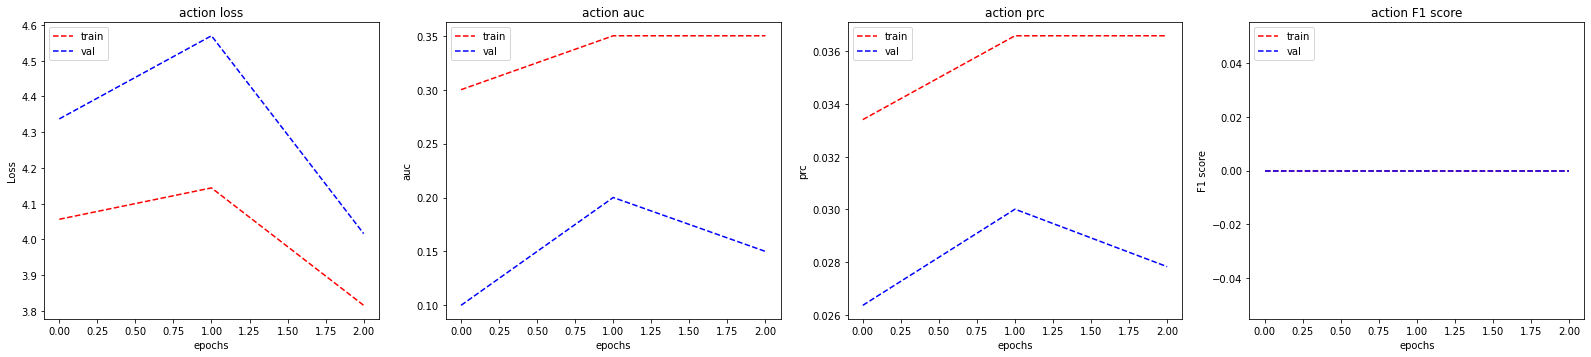

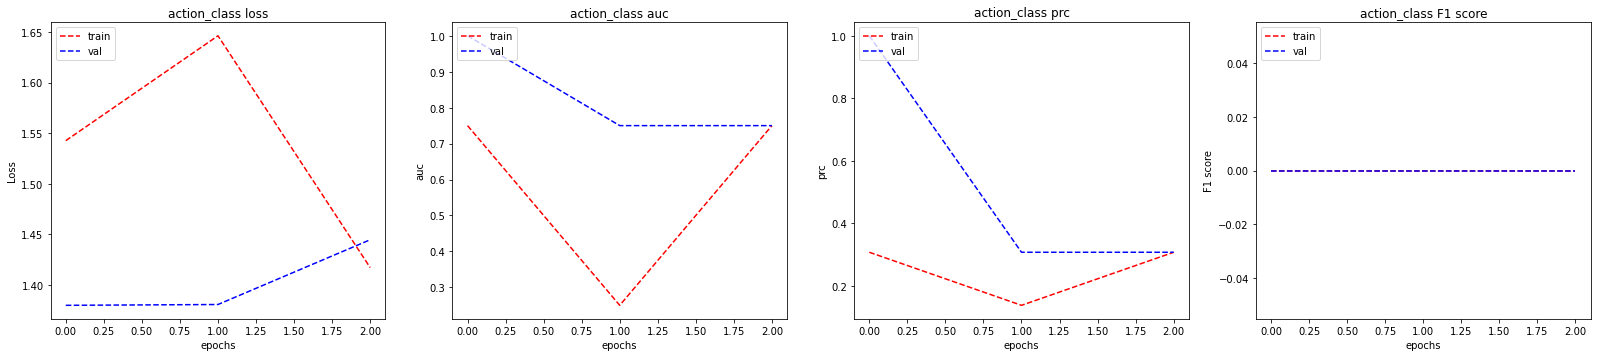

In [81]:
# Plot the results for run though of the data (epoch).
plot_learning_curve(test_history, parameters["metrics"], ["action", "action_class"])

Creating, Checkpointing, Updating Histories, and Plotting tested and is working!


## 5.2 Model Approach

#### Base Model
When choosing the base model the EDA says that..

#### Learning Rate
Starting the learning rate at 0.001 because..

#### Optimizer Chosen
The Adam Optimizer was chosen because ..

The data set is relatively small, and the dataset used in the base model is similar to our dataset. This means that tuning the base model is not needed, and only the classifier on the top needs to be trained and tuned.

## 5.2.1 - Head Model

Due to transfer learning having a similar dataset, it means the head does not need many layers at all to make this task perform well.*italicized text*

### InceptionV3

#### Model 1

##### Init

In [82]:
METRICS_CI = [
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc',curve='ROC',),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

learning_rate = 0.001

batches_per_epoch = train_generator.__len__()

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  learning_rate,
  decay_steps=batches_per_epoch * 1000,
  decay_rate=10,
  staircase=False)

# Hyperparameters.
parameters = {
    # Compile parameters.
    "optimizer": tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    "loss": tf.keras.losses.CategoricalCrossentropy(),
    "metrics": METRICS_CI,

    # Generator Parameters.
    "batch_size": 4,

    # Fit perameters.
    "epochs": 5
}

reg_lambda = 0.001

# Model
IMG_SHAPE = (None,None, 3)
inputs = keras.Input(shape=IMG_SHAPE)
base_model = tf.keras.applications.InceptionV3(input_tensor=inputs, 
                                               include_top=False, 
                                               weights='imagenet')

for layer in base_model.layers:
  layer.trainable = False

x = base_model.output
x = tf.keras.layers.BatchNormalization(momentum=.4)(x)

model = create_resnet_model(x, [], [], IMG_SHAPE, reg_lambda=reg_lambda)
model.summary()
model_name = "initial_model"

Model: "mnist_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_98 (Conv2D)              (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_99 (BatchNo (None, None, None, 3 96          conv2d_98[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, None, None, 3 0           batch_normalization_99[0][0]     
________________________________________________________________________________________

##### Train

In [83]:
train_generator = DataGenerator(train_set, data_mean=data_mean, data_std=data_std, augmentations=train_augmentations, directory=directory, batch_size=parameters["batch_size"])
val_generator = DataGenerator(validation_set, data_mean=data_mean, data_std=data_std, directory=directory, batch_size=parameters["batch_size"])

history, model = run_model(model, parameters, model_name, train_generator, val_generator)

~~~~~~~~~~ initial_model ~~~~~~~~~~
/bin/bash: /: Is a directory
Accessed: /content/drive/My Drive/Deep_Learning/models/initial_model/checkpoint.tf
Accessed: /content/drive/My Drive/Deep_Learning/models/initial_model/history.csv


##### Eval

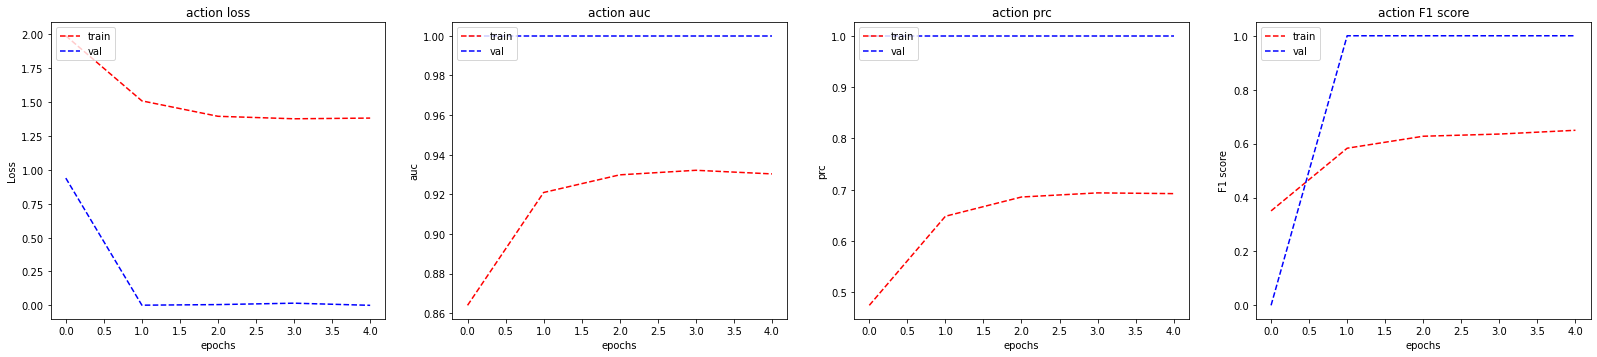

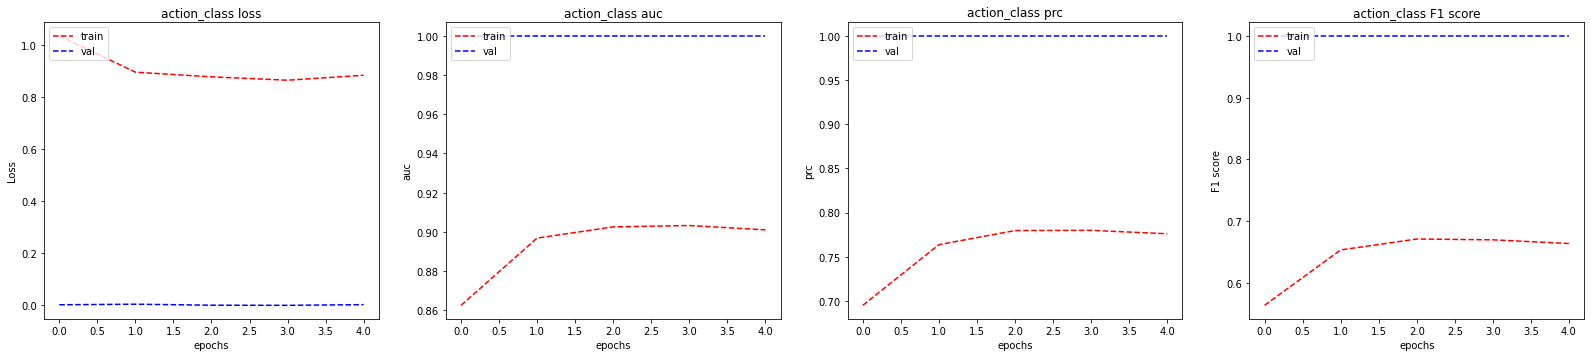

In [84]:
# Plot the results for run though of the data (epoch).
plot_learning_curve(history, parameters["metrics"], ["action", "action_class"])

🧐 **Observations:**
> - 100% F1 score after 1 epoch
> - Training plateud at about 70% accuracy

👨🏻‍🎓 **Conclusions**
> - Half the Learning rate to 0.0005
> - Add dense layer for improving training accuracy and learning.


#### Model 2

##### Init

In [85]:
learning_rate = 0.0005

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  learning_rate,
  decay_steps=batches_per_epoch * 1000,
  decay_rate=10,
  staircase=False)

# Hyperparameters.
parameters["optimizer"] = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

x = base_model.output
x = tf.keras.layers.Dense(64, 
                          activation=tf.nn.softmax, 
                          kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),
                          kernel_initializer="he_normal")(x)
x = tf.keras.layers.BatchNormalization(momentum=.4)(x)

model = create_resnet_model(x, [], [], IMG_SHAPE, reg_lambda=reg_lambda)
model.summary()
model_name = "initial_model_iv3_a"

Model: "mnist_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_98 (Conv2D)              (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_99 (BatchNo (None, None, None, 3 96          conv2d_98[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, None, None, 3 0           batch_normalization_99[0][0]     
________________________________________________________________________________________

##### Train

In [86]:
train_generator = DataGenerator(train_set, data_mean=data_mean, data_std=data_std, augmentations=train_augmentations, directory=directory, batch_size=parameters["batch_size"])
val_generator = DataGenerator(validation_set, data_mean=data_mean, data_std=data_std, directory=directory, batch_size=parameters["batch_size"])

history, model = run_model(model, parameters, model_name, train_generator, val_generator)

~~~~~~~~~~ initial_model_iv3_a ~~~~~~~~~~
/bin/bash: /: Is a directory
Accessed: /content/drive/My Drive/Deep_Learning/models/initial_model_iv3_a/checkpoint.tf
Accessed: /content/drive/My Drive/Deep_Learning/models/initial_model_iv3_a/history.csv


##### Eval

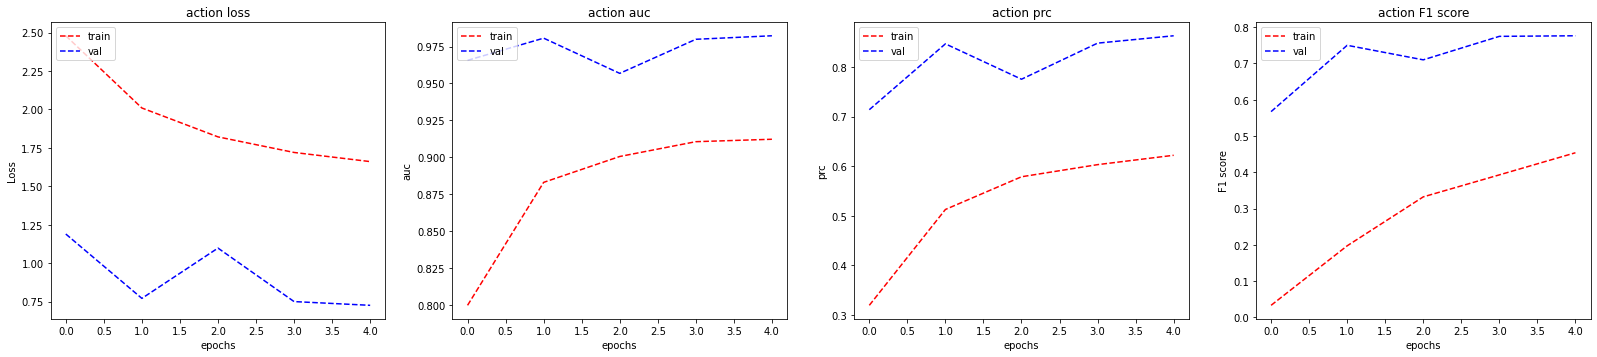

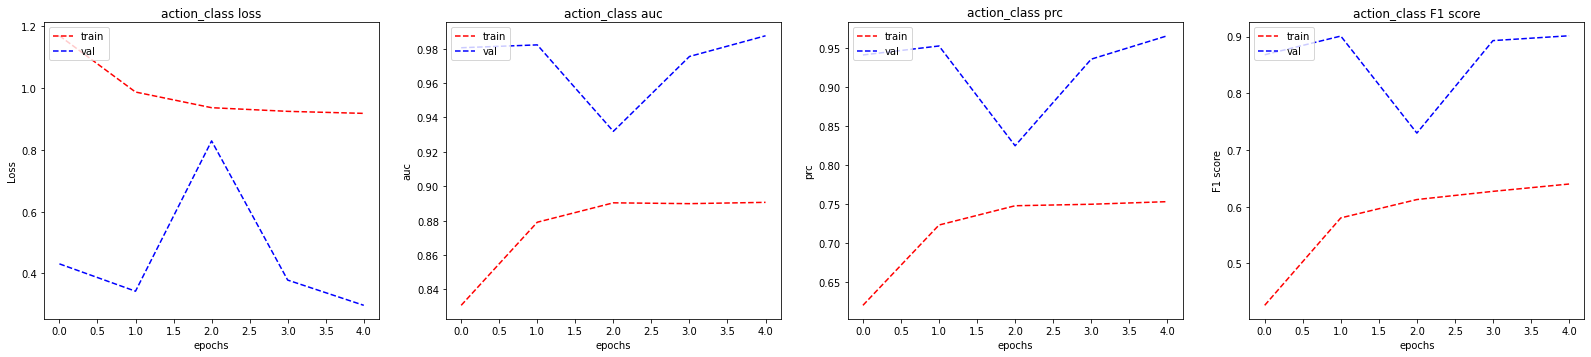

In [87]:
# Plot the results for run though of the data (epoch).
plot_learning_curve(history, parameters["metrics"], ["action", "action_class"])

🧐 **Observations:**
> - Underfitted

👨🏻‍🎓 **Conclusions**
> - Increase Learning Rate to 0.0007
> - Increase Epochs to 12



#### Model 3

##### Init

In [88]:
# Hyperparameters.
parameters["epochs"] = 20

x = base_model.output
x = tf.keras.layers.Dense(64, 
                          activation=tf.nn.softmax, 
                          kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),
                          kernel_initializer="he_normal")(x)
x = tf.keras.layers.BatchNormalization(momentum=.4)(x)

model = create_resnet_model(x, [], [], IMG_SHAPE, reg_lambda=reg_lambda)
model.summary()
model_name = "initial_model_iv3_2"

Model: "mnist_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_98 (Conv2D)              (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_99 (BatchNo (None, None, None, 3 96          conv2d_98[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, None, None, 3 0           batch_normalization_99[0][0]     
________________________________________________________________________________________

##### Train

In [89]:
train_generator = DataGenerator(train_set, data_mean=data_mean, data_std=data_std, augmentations=train_augmentations, directory=directory, batch_size=parameters["batch_size"])
val_generator = DataGenerator(validation_set, data_mean=data_mean, data_std=data_std, directory=directory, batch_size=parameters["batch_size"])

history, model = run_model(model, parameters, model_name, train_generator, val_generator)

~~~~~~~~~~ initial_model_iv3_2 ~~~~~~~~~~
/bin/bash: /: Is a directory
Accessed: /content/drive/My Drive/Deep_Learning/models/initial_model_iv3_2/checkpoint.tf
Accessed: /content/drive/My Drive/Deep_Learning/models/initial_model_iv3_2/history.csv


##### Eval

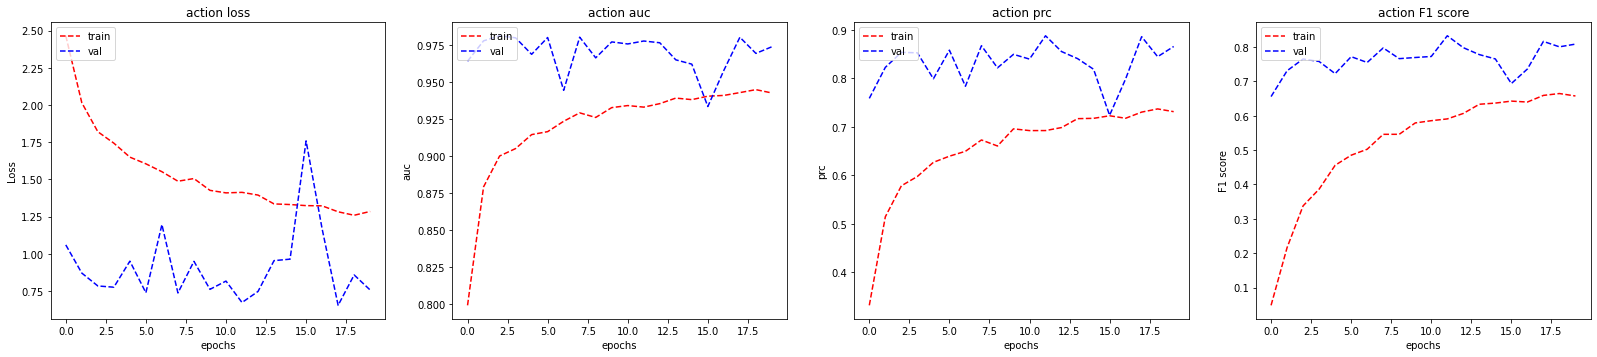

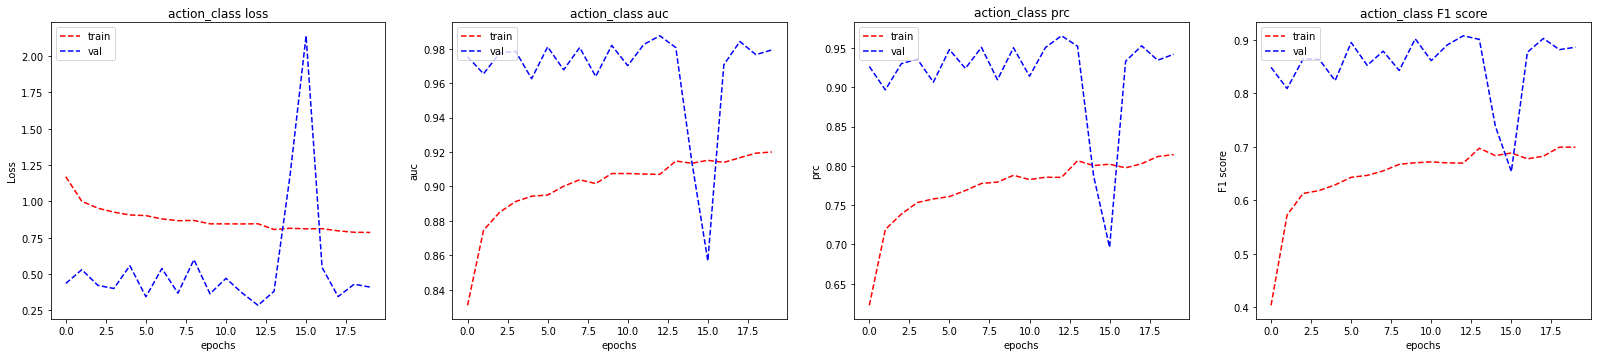

In [90]:
# Plot the results for run though of the data (epoch).
plot_learning_curve(history, parameters["metrics"], ["action", "action_class"])

🧐 **Observations:**
> - The dense layer is put before the global average pool

👨🏻‍🎓 **Conclusions**
> - Put dense layer afterr the global average pool


#### Model 4

##### Init

In [91]:
# Hyperparameters.
parameters["epochs"] = 20

x = base_model.output
final = tf.keras.layers.Dense(64, 
                          activation=tf.nn.softmax, 
                          kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),
                          kernel_initializer="he_normal")

model = create_resnet_model(x, [], [], IMG_SHAPE, reg_lambda=reg_lambda, final=final)
model.summary()
model_name = "initial_model_iv3_3"

Model: "mnist_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_98 (Conv2D)              (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_99 (BatchNo (None, None, None, 3 96          conv2d_98[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, None, None, 3 0           batch_normalization_99[0][0]     
________________________________________________________________________________________

##### Train

In [92]:
train_generator = DataGenerator(train_set, data_mean=data_mean, data_std=data_std, augmentations=train_augmentations, directory=directory, batch_size=parameters["batch_size"])
val_generator = DataGenerator(validation_set, data_mean=data_mean, data_std=data_std, directory=directory, batch_size=parameters["batch_size"])

history, model = run_model(model, parameters, model_name, train_generator, val_generator)

~~~~~~~~~~ initial_model_iv3_3 ~~~~~~~~~~
/bin/bash: /: Is a directory
Accessed: /content/drive/My Drive/Deep_Learning/models/initial_model_iv3_3/checkpoint.tf
Accessed: /content/drive/My Drive/Deep_Learning/models/initial_model_iv3_3/history.csv


##### Eval

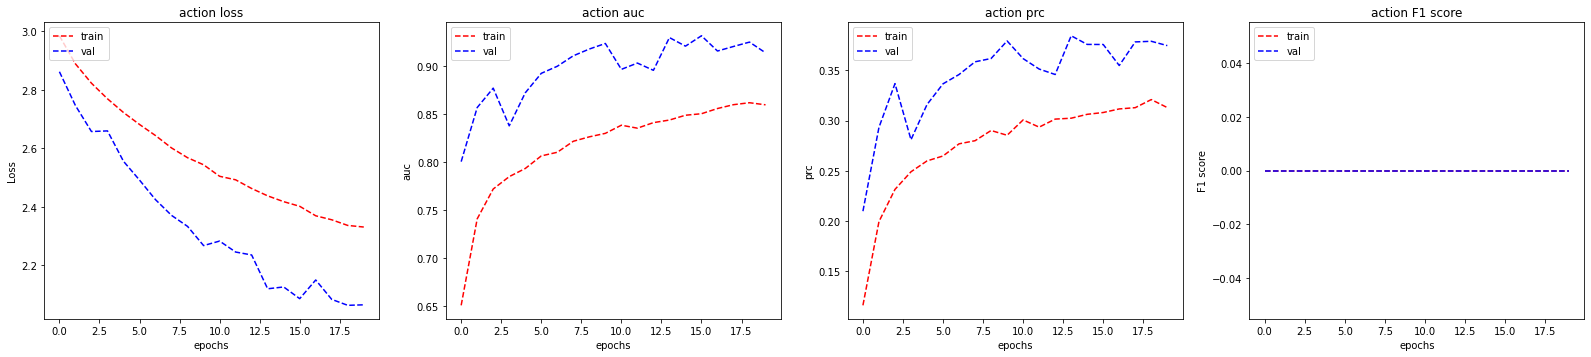

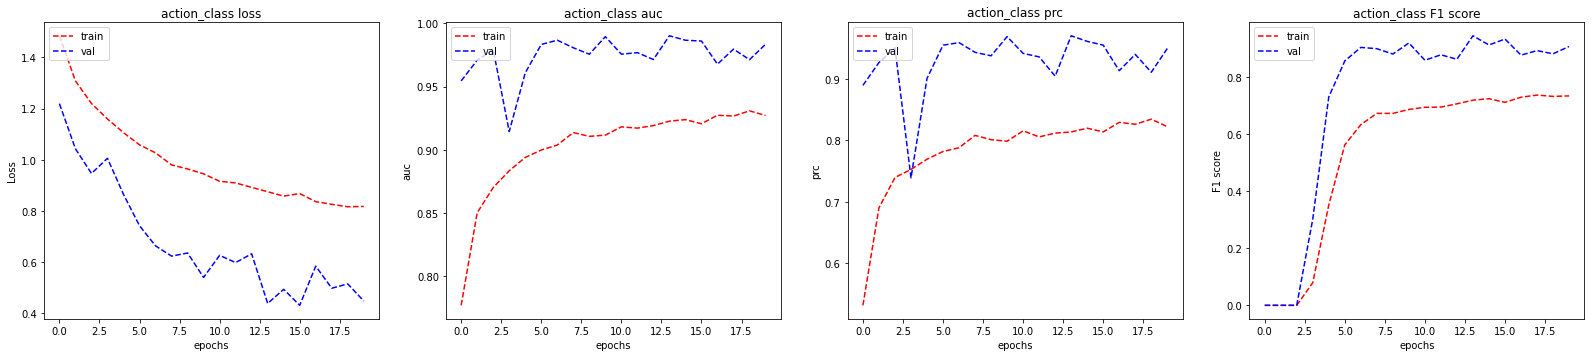

In [93]:
# Plot the results for run though of the data (epoch).
plot_learning_curve(history, parameters["metrics"], ["action", "action_class"])

🧐 **Observations:**
> - Severely Underfitted

👨🏻‍🎓 **Conclusions**
> - With more training time and implementation of resnet block, this would train a lot better


#### Model 5

##### Init

In [94]:
# Hyperparameters.
parameters["epochs"] = 150

x = base_model.output
final = tf.keras.layers.Dense(64, 
                          activation=tf.nn.softmax, 
                          kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),
                          kernel_initializer="he_normal")

model = create_resnet_model(x, [], [], IMG_SHAPE, reg_lambda=reg_lambda, final=final)
model.summary()
model_name = "beast_model_suck_my_dick"

Model: "mnist_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_98 (Conv2D)              (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_99 (BatchNo (None, None, None, 3 96          conv2d_98[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, None, None, 3 0           batch_normalization_99[0][0]     
________________________________________________________________________________________

##### Train

In [95]:
train_generator = DataGenerator(train_set, data_mean=data_mean, data_std=data_std, augmentations=train_augmentations, directory=directory, batch_size=parameters["batch_size"])
val_generator = DataGenerator(validation_set, data_mean=data_mean, data_std=data_std, directory=directory, batch_size=parameters["batch_size"])

history, model = run_model(model, parameters, model_name, train_generator, val_generator)

~~~~~~~~~~ beast_model_suck_my_dick ~~~~~~~~~~
/bin/bash: /: Is a directory
Accessed: /content/drive/My Drive/Deep_Learning/models/beast_model_suck_my_dick/checkpoint.tf
Accessed: /content/drive/My Drive/Deep_Learning/models/beast_model_suck_my_dick/history.csv


##### Eval

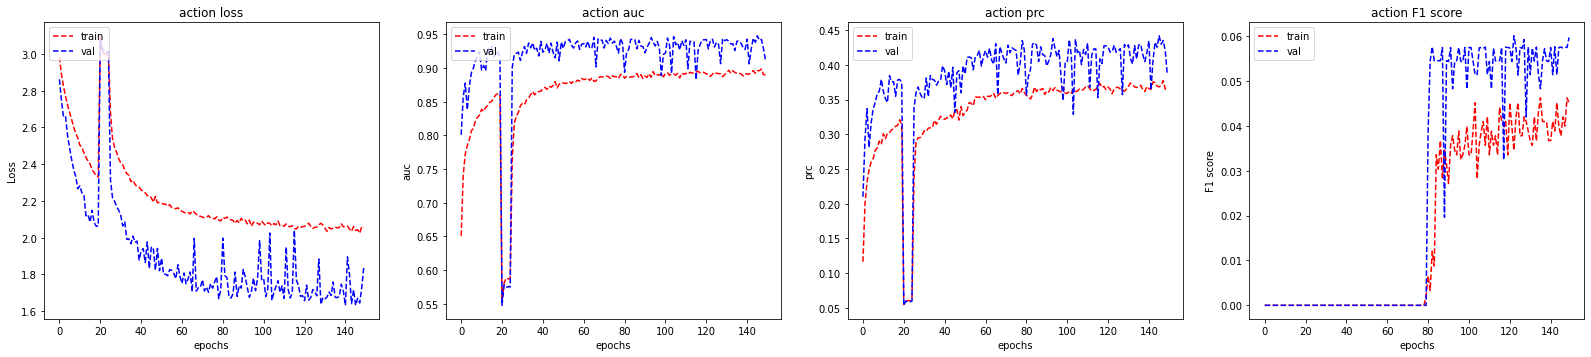

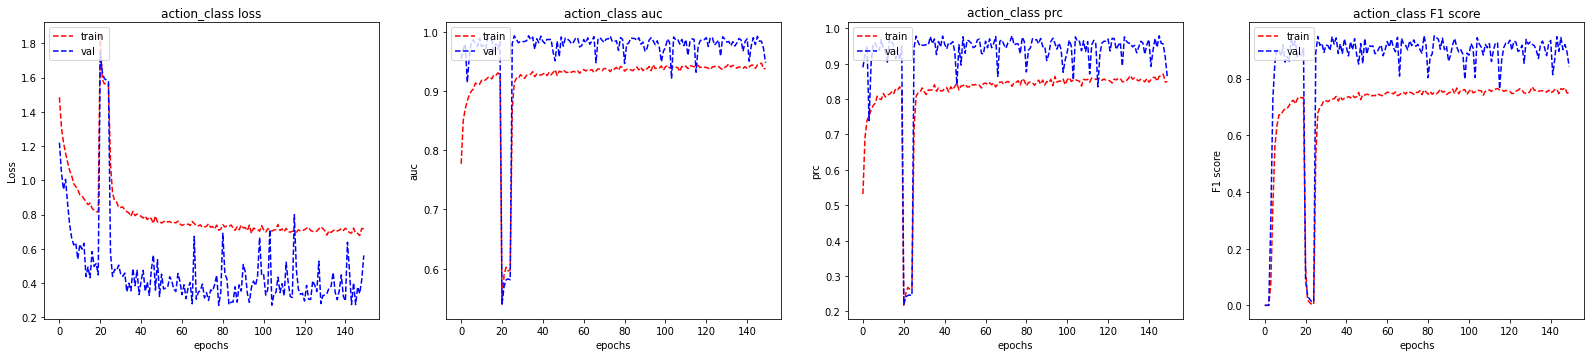

In [96]:
# Plot the results for run though of the data (epoch).
plot_learning_curve(history, parameters["metrics"], ["action", "action_class"])

🧐 **Observations:**
> - Severely Underfitted

👨🏻‍🎓 **Conclusions**
> - With more training time and implementation of resnet block, this would train a lot better


#### Model 6

##### Init

In [99]:
beast_augmentations = [
    __aug_rotate,       
    __aug_brighten,     
    # __aug_hue,
    __aug_saturation,
    __aug_flip,     
    # __aug_quality, 
    __aug_contrast, 
    # __shift_aug
]

learning_rate = 0.0007

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  learning_rate,
  decay_steps=batches_per_epoch * 1000,
  decay_rate=10,
  staircase=False)

# Hyperparameters.
parameters["optimizer"] = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
parameters["epochs"] = 40
parameters["batch_size"] = 32

x = base_model.output

# Final
final = tf.keras.layers.Dense(64, 
                          activation=tf.nn.softmax, 
                          kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),
                          kernel_initializer="he_normal")

model = create_resnet_model(x, [], [], IMG_SHAPE, reg_lambda=reg_lambda, final=final)
model.summary()
model_name = "beast_model_60_40"

Model: "mnist_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_98 (Conv2D)              (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_99 (BatchNo (None, None, None, 3 96          conv2d_98[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, None, None, 3 0           batch_normalization_99[0][0]     
________________________________________________________________________________________

##### Train

In [100]:
train_generator = DataGenerator(train_set, data_mean=data_mean, data_std=data_std, augmentations=beast_augmentations, directory=directory, batch_size=parameters["batch_size"])
val_generator = DataGenerator(validation_set, data_mean=data_mean, data_std=data_std, directory=directory, batch_size=parameters["batch_size"], shuffle=False)

history, model = run_model(model, parameters, model_name, train_generator, val_generator)

~~~~~~~~~~ beast_model_60_40 ~~~~~~~~~~
/bin/bash: /: Is a directory
Creating new model..

Epoch 00001: loss improved from inf to 4.57695, saving model to /content/drive/My Drive/Deep_Learning/models/beast_model_60_40/checkpoint.tf
INFO:tensorflow:Assets written to: /content/drive/My Drive/Deep_Learning/models/beast_model_60_40/checkpoint.tf/assets
Epoch 1/40 Complete

Epoch 00002: loss improved from 4.57695 to 4.33368, saving model to /content/drive/My Drive/Deep_Learning/models/beast_model_60_40/checkpoint.tf
INFO:tensorflow:Assets written to: /content/drive/My Drive/Deep_Learning/models/beast_model_60_40/checkpoint.tf/assets
Epoch 2/40 Complete

Epoch 00003: loss improved from 4.33368 to 4.19842, saving model to /content/drive/My Drive/Deep_Learning/models/beast_model_60_40/checkpoint.tf
INFO:tensorflow:Assets written to: /content/drive/My Drive/Deep_Learning/models/beast_model_60_40/checkpoint.tf/assets
Epoch 3/40 Complete

Epoch 00004: loss improved from 4.19842 to 4.09158, saving

##### Eval

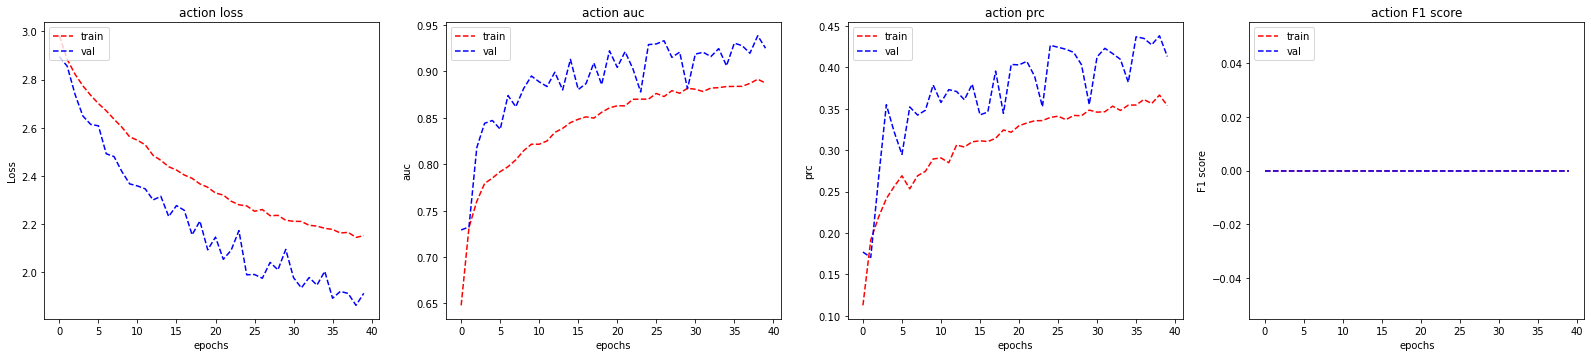

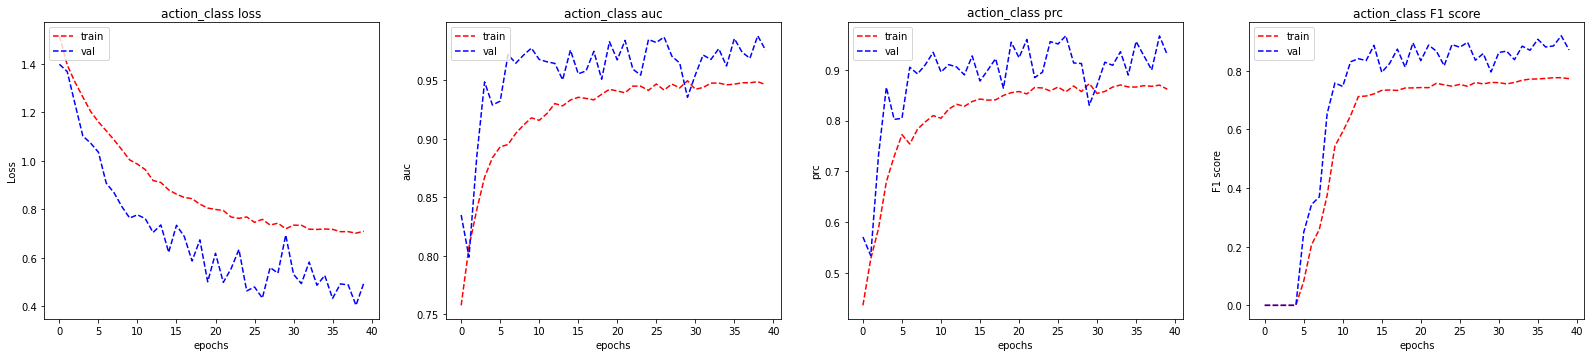

In [101]:
# Plot the results for run though of the data (epoch).
plot_learning_curve(history, parameters["metrics"], ["action", "action_class"])

🧐 **Observations:**
> - Severely Underfitted

👨🏻‍🎓 **Conclusions**
> - With more training time and implementation of resnet block, this would train a lot better


#### Model 7

##### Init

In [102]:
learning_rate = 0.0007

beast_augmentations = [
    __aug_rotate,       
    __aug_brighten,     
    # __aug_hue,
    __aug_saturation,
    __aug_flip,     
    # __aug_quality, 
    __aug_contrast, 
    # __shift_aug
]

# Hyperparameters.
# parameters["epochs"] = 40
# parameters["batch_size"] = 32

x = base_model.output

# Final
final = tf.keras.layers.Dense(64, 
                          activation=tf.nn.softmax, 
                          kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),
                          kernel_initializer="he_normal")

model = create_resnet_model(x, [], [], IMG_SHAPE, reg_lambda=reg_lambda, final=final)
model.summary()
model_name = "beast_model_80_20"

Model: "mnist_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_98 (Conv2D)              (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_99 (BatchNo (None, None, None, 3 96          conv2d_98[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, None, None, 3 0           batch_normalization_99[0][0]     
________________________________________________________________________________________

##### Train

In [ ]:
train_generator = DataGenerator(train_set_80_20, data_mean=data_mean, data_std=data_std, augmentations=beast_augmentations, directory=directory, batch_size=parameters["batch_size"])
val_generator = DataGenerator(validation_set_80_20, data_mean=data_mean, data_std=data_std, directory=directory, batch_size=parameters["batch_size"], shuffle=False)

history, model = run_model(model, parameters, model_name, train_generator, val_generator)

~~~~~~~~~~ beast_model_80_20 ~~~~~~~~~~
/bin/bash: /: Is a directory
Creating new model..

Epoch 00001: loss improved from inf to 4.43310, saving model to /content/drive/My Drive/Deep_Learning/models/beast_model_80_20/checkpoint.tf
INFO:tensorflow:Assets written to: /content/drive/My Drive/Deep_Learning/models/beast_model_80_20/checkpoint.tf/assets
Epoch 1/40 Complete

Epoch 00002: loss improved from 4.43310 to 4.12733, saving model to /content/drive/My Drive/Deep_Learning/models/beast_model_80_20/checkpoint.tf
INFO:tensorflow:Assets written to: /content/drive/My Drive/Deep_Learning/models/beast_model_80_20/checkpoint.tf/assets
Epoch 2/40 Complete

Epoch 00003: loss improved from 4.12733 to 3.97679, saving model to /content/drive/My Drive/Deep_Learning/models/beast_model_80_20/checkpoint.tf
INFO:tensorflow:Assets written to: /content/drive/My Drive/Deep_Learning/models/beast_model_80_20/checkpoint.tf/assets
Epoch 3/40 Complete

Epoch 00004: loss improved from 3.97679 to 3.86832, saving

##### Eval

In [ ]:
# Plot the results for run though of the data (epoch).
plot_learning_curve(history, parameters["metrics"], ["action", "action_class"])

🧐 **Observations:**
> - Severely Underfitted

👨🏻‍🎓 **Conclusions**
> - With more training time and implementation of resnet block, this would train a lot better


#### Model 7

##### Init

In [ ]:
beast_augmentations = [
    __aug_rotate,       
    __aug_brighten,     
    # __aug_hue,
    __aug_saturation,
    __aug_flip,     
    # __aug_quality, 
    __aug_contrast, 
    # __shift_aug
]

learning_rate = 0.0007

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  learning_rate,
  decay_steps=batches_per_epoch * 1000,
  decay_rate=10,
  staircase=False)

# Hyperparameters.
parameters["optimizer"] = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
parameters["epochs"] = 40
parameters["batch_size"] = 32
x = base_model.output

# NO Final Layer
x = tf.keras.layers.Dense(64, 
                          activation=tf.nn.softmax, 
                          kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),
                          kernel_initializer="he_normal")(x)

model = create_resnet_model(x, [], [], IMG_SHAPE, reg_lambda=reg_lambda)
model.summary()
model_name = "beast_model_80_20"

Model: "mnist_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_98 (Conv2D)              (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_99 (BatchNo (None, None, None, 3 96          conv2d_98[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, None, None, 3 0           batch_normalization_99[0][0]     
________________________________________________________________________________________

##### Train

In [ ]:
train_generator = DataGenerator(train_set_80_20, data_mean=data_mean, data_std=data_std, augmentations=beast_augmentations, directory=directory, batch_size=parameters["batch_size"])
val_generator = DataGenerator(validation_set_80_20, data_mean=data_mean, data_std=data_std, directory=directory, batch_size=parameters["batch_size"], shuffle=False)

history, model = run_model(model, parameters, model_name, train_generator, val_generator)

~~~~~~~~~~ beast_model_80_20 ~~~~~~~~~~
/bin/bash: /: Is a directory


Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x7fa124126b90>
Traceback (most recent call last):
  File "/usr/lib/python3.7/weakref.py", line 358, in remove
    def remove(k, selfref=ref(self)):
KeyboardInterrupt


Accessed: /content/drive/My Drive/Deep_Learning/models/beast_model_80_20/checkpoint.tf
Accessed: /content/drive/My Drive/Deep_Learning/models/beast_model_80_20/history.csv
Continuing training model ...
Epochs done: 6
Epochs left: 34


KeyboardInterrupt: ignored

##### Eval

In [ ]:
# Plot the results for run though of the data (epoch).
plot_learning_curve(history, parameters["metrics"], ["action", "action_class"])

🧐 **Observations:**
> - Severely Underfitted

👨🏻‍🎓 **Conclusions**
> - With more training time and implementation of resnet block, this would train a lot better


### MobileNetV2

#### Model 1

##### Init

In [ ]:
METRICS_CI = [
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc',curve='ROC',),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

learning_rate = 0.001

batches_per_epoch = train_generator.__len__()

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  learning_rate,
  decay_steps=batches_per_epoch * 1000,
  decay_rate=10,
  staircase=False)

# Hyperparameters.
parameters = {
    # Compile parameters.
    "optimizer": tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    "loss": tf.keras.losses.CategoricalCrossentropy(),
    "metrics": METRICS_CI,

    # Generator Parameters.
    "batch_size": 32,

    # Fit perameters.
    "epochs": 3
}

reg_lambda = 0.001

# Model
IMG_SHAPE = (None,None, 3)
inputs = keras.Input(shape=IMG_SHAPE)
base_model = tf.keras.applications.MobileNetV2(input_tensor=inputs, 
                                               include_top=False, 
                                               weights='imagenet')

for layer in base_model.layers:
  layer.trainable = False
  
x = base_model.output
x = tf.keras.layers.BatchNormalization(momentum=.4)(x)

model = create_resnet_model(x, [], [], IMG_SHAPE, reg_lambda=reg_lambda)
model.summary()
model_name = "initial_model_2"

##### Train

In [ ]:
train_generator = DataGenerator(train_set, data_mean=data_mean, data_std=data_std, augmentations=train_augmentations, directory=directory, batch_size=parameters["batch_size"])
val_generator = DataGenerator(validation_set, data_mean=data_mean, data_std=data_std, directory=directory, batch_size=parameters["batch_size"])

history, model = run_model(model, parameters, model_name, train_generator, val_generator)

##### Eval

In [ ]:
# Plot the results for run though of the data (epoch).
plot_learning_curve(history, parameters["metrics"], ["action", "action_class"])

🧐 **Observations:**
> - Though a lot less than before, there is still overfitting being present  when just using the base model.

👨🏻‍🎓 **Conclusions**
> - Use less complex base model
> - Experiment with SGD optimizer

#### Model 2

##### Init

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  learning_rate,
  decay_steps=batches_per_epoch * 1000,
  decay_rate=10,
  staircase=False)

# Hyperparameters.
parameters["optimizer"] = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

# Model
IMG_SHAPE = (None,None, 3)
inputs = keras.Input(shape=IMG_SHAPE)
base_model = tf.keras.applications.MobileNetV2(input_tensor=inputs, 
                                               include_top=False, 
                                               weights='imagenet')

for layer in base_model.layers:
  layer.trainable = False
  
x = base_model.output
x = tf.keras.layers.BatchNormalization(momentum=.4)(x)

model = create_resnet_model(x, [], [], IMG_SHAPE, reg_lambda=reg_lambda)
model.summary()
model_name = "initial_model_3"

##### Train

In [ ]:
train_generator = DataGenerator(train_set, data_mean=data_mean, data_std=data_std, augmentations=train_augmentations, directory=directory, batch_size=parameters["batch_size"])
val_generator = DataGenerator(validation_set, data_mean=data_mean, data_std=data_std, directory=directory, batch_size=parameters["batch_size"])

history, model = run_model(model, parameters, model_name, train_generator, val_generator)

##### Eval

In [ ]:
# Plot the results for run though of the data (epoch).
plot_learning_curve(history, parameters["metrics"], ["action", "action_class"])

🧐 **Observations:**
> - Again a lot less than before, there is still overfitting on the first epoch when just using the base model.
> - SDG optimiser made the f1 score 10x worse than Adam optimiser because Adam is a lot faster.
> - SDG is slow and "produces the same performance as regular gradient descent when the learning rate is low" [1]

👨🏻‍🎓 **Conclusions**
> - Use Adam Optimizer again
> - Lower learning rate to 0.0005

[1] [SDG vs Adam](https://medium.com/syncedreview/iclr-2019-fast-as-adam-good-as-sgd-new-optimizer-has-both-78e37e8f9a34)

#### Model 3

##### Init

In [ ]:
learning_rate = 0.0005

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  learning_rate,
  decay_steps=batches_per_epoch * 1000,
  decay_rate=10,
  staircase=False)

# Hyperparameters.
parameters["optimizer"] = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Model
IMG_SHAPE = (None,None, 3)
inputs = keras.Input(shape=IMG_SHAPE)
base_model = tf.keras.applications.MobileNetV2(input_tensor=inputs, 
                                               include_top=False, 
                                               weights='imagenet')

for layer in base_model.layers:
  layer.trainable = False
  
x = base_model.output
x = tf.keras.layers.BatchNormalization(momentum=.4)(x)

model = create_resnet_model(x, [], [], IMG_SHAPE, reg_lambda=reg_lambda)
model.summary()
model_name = "initial_model_4"

##### Train

In [ ]:
train_generator = DataGenerator(train_set, data_mean=data_mean, data_std=data_std, augmentations=train_augmentations, directory=directory, batch_size=parameters["batch_size"])
val_generator = DataGenerator(validation_set, data_mean=data_mean, data_std=data_std, directory=directory, batch_size=parameters["batch_size"])

history, model = run_model(model, parameters, model_name, train_generator, val_generator)

##### Eval

In [ ]:
# Plot the results for run though of the data (epoch).
plot_learning_curve(history, parameters["metrics"], ["action", "action_class"])

🧐 **Observations:**
> - Accuracy is on it's way up
> - Loss not at 0, and still on its way down

👨🏻‍🎓 **Conclusions**
> - Increase epochs to 20

#### Model 4

##### Init

In [ ]:
# Hyperparameters.
parameters["epochs"] = 20

model_name = "initial_model_5"

##### Train

In [ ]:
train_generator = DataGenerator(train_set, data_mean=data_mean, data_std=data_std, augmentations=train_augmentations, directory=directory, batch_size=parameters["batch_size"])
val_generator = DataGenerator(validation_set, data_mean=data_mean, data_std=data_std, directory=directory, batch_size=parameters["batch_size"])

history, model = run_model(model, parameters, model_name, train_generator, val_generator)

##### Eval

In [ ]:
# Plot the results for run though of the data (epoch).
plot_learning_curve(history, parameters["metrics"], ["action", "action_class"])

🧐 **Observations:**
> - loss improved from 2.55881 to 2.48941 on epoch 15
> - Loss not at 0, and still on its way down
> - Training is very slow and is almost linear

👨🏻‍🎓 **Conclusions**
> - Decrease epochs to 10
<!-- > - Increase the learning rate decay
> - Increase learning rate to 0.001 -->
> - Add Conv2D layer after general average pooling layer to create a learning  block

#### Model 5

##### Init

In [ ]:
# Hyperparameters.
parameters["epochs"] = 10
  
# Model
x = base_model.output
x = tf.keras.layers.Conv2D(filters=16,
                                kernel_size=(3, 3),
                                strides=1,
                                kernel_initializer="he_normal",
                                kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),
                                padding="same")(x)
x = tf.keras.layers.BatchNormalization(momentum=.4)(x)


model = create_resnet_model(x, [], [], IMG_SHAPE, reg_lambda=reg_lambda)
model.summary()
model_name = "initial_model_6"

##### Train

In [ ]:
train_generator = DataGenerator(train_set, data_mean=data_mean, data_std=data_std, augmentations=train_augmentations, directory=directory, batch_size=parameters["batch_size"])
val_generator = DataGenerator(validation_set, data_mean=data_mean, data_std=data_std, directory=directory, batch_size=parameters["batch_size"])

history, model = run_model(model, parameters, model_name, train_generator, val_generator)

##### Eval

In [ ]:
# Plot the results for run though of the data (epoch).
plot_learning_curve(history, parameters["metrics"], ["action", "action_class"])

🧐 **Observations:**
> - Trraining loss plateus after 8 epochs
> - Training speed was relatively quick for 180K parameters.
> - F1 Score of 0.5 which is really bad
> - Underfitting

👨🏻‍🎓 **Conclusions**
> - Add a resnet block to the model head that does two convosuion layers seperated by batch normalisation, to insight further learning.

#### Model 6

##### Init

In [ ]:
# Hyperparameters.
parameters["epochs"] = 10

# Model
x = base_model.output
model = create_resnet_model(x, [32], [1], IMG_SHAPE, reg_lambda=reg_lambda)

model.summary()
model_name = "initial_model_block"

##### Train

In [ ]:
train_generator = DataGenerator(train_set, data_mean=data_mean, data_std=data_std, augmentations=train_augmentations, directory=directory, batch_size=parameters["batch_size"])
val_generator = DataGenerator(validation_set, data_mean=data_mean, data_std=data_std, directory=directory, batch_size=parameters["batch_size"])

history, model = run_model(model, parameters, model_name, train_generator, val_generator)

##### Eval

In [ ]:
# Plot the results for run though of the data (epoch).
plot_learning_curve(history, parameters["metrics"], ["action", "action_class"])

🧐 **Observations:**
> - Validation still converging with training
> - Underfitted
> - Increased in learning threshhold from the added resnet block.

👨🏻‍🎓 **Conclusions**
> - Increase epochs to 30

#### Model 7

##### Init

In [ ]:
# Hyperparameters.
parameters["epochs"] = 30

# Model
x = base_model.output
model = create_resnet_model(x, [32], [1], IMG_SHAPE, reg_lambda=reg_lambda)

model.summary()
model_name = "initial_model_block_2"

##### Train

In [ ]:
train_generator = DataGenerator(train_set, data_mean=data_mean, data_std=data_std, augmentations=train_augmentations, directory=directory, batch_size=parameters["batch_size"])
val_generator = DataGenerator(validation_set, data_mean=data_mean, data_std=data_std, directory=directory, batch_size=parameters["batch_size"])

history, model = run_model(model, parameters, model_name, train_generator, val_generator)

##### Eval

In [ ]:
# Plot the results for run though of the data (epoch).
plot_learning_curve(history, parameters["metrics"], ["action", "action_class"])

🧐 **Observations:**
> - still slightly underfitted

👨🏻‍🎓 **Conclusions**
> - Increase learning rate to 0.0007

#### Model 8

##### Init

In [ ]:
learning_rate = 0.0007

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  learning_rate,
  decay_steps=batches_per_epoch * 1000,
  decay_rate=10,
  staircase=False)

# Hyperparameters.
parameters["optimizer"] = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Model
x = base_model.output
model = create_resnet_model(x, [32], [1], IMG_SHAPE, reg_lambda=reg_lambda)

model.summary()
model_name = "initial_model_block_3"

##### Train

In [ ]:
train_generator = DataGenerator(train_set, data_mean=data_mean, data_std=data_std, augmentations=train_augmentations, directory=directory, batch_size=parameters["batch_size"])
val_generator = DataGenerator(validation_set, data_mean=data_mean, data_std=data_std, directory=directory, batch_size=parameters["batch_size"])

history, model = run_model(model, parameters, model_name, train_generator, val_generator)

##### Eval

In [ ]:
# Plot the results for run though of the data (epoch).
plot_learning_curve(history, parameters["metrics"], ["action", "action_class"])

🧐 **Observations:**
> - Aproximately a 90% accuracy score from the metrics
> - Validation doesn't seem to increase much, from beginning, which indcates that the model head is not learning much, and most learning has come from base model.
> - validation loss is chaotic and doesn't settle much.

👨🏻‍🎓 **Conclusions**
> - Add dense layer afterr global average pool to insight learning after pooling.
> - Decrease learning rate to 0.0005 so the validation loss is not so chaotic and finds minima.

#### Model 9

##### Init

In [ ]:
learning_rate = 0.0005

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  learning_rate,
  decay_steps=batches_per_epoch * 1000,
  decay_rate=10,
  staircase=False)

# Hyperparameters.
parameters["epochs"] = 40
parameters["optimizer"] = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

final = tf.keras.layers.Dense(64, 
                          activation=tf.nn.softmax, 
                          kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),
                          kernel_initializer="he_normal")

# Model
x = base_model.output
model = create_resnet_model(x, [32], [1], IMG_SHAPE, reg_lambda=reg_lambda, final=final)

model.summary()
model_name = "initial_model_block_5"

##### Train

In [ ]:
train_generator = DataGenerator(train_set, data_mean=data_mean, data_std=data_std, augmentations=train_augmentations, directory=directory, batch_size=parameters["batch_size"])
val_generator = DataGenerator(validation_set, data_mean=data_mean, data_std=data_std, directory=directory, batch_size=parameters["batch_size"])

history, model = run_model(model, parameters, model_name, train_generator, val_generator)

##### Eval

In [ ]:
# Plot the results for run though of the data (epoch).
plot_learning_curve(history, parameters["metrics"], ["action", "action_class"])

🧐 **Observations:**
> - still slightly underfitted

👨🏻‍🎓 **Conclusions**
> - Increase epochs to 40
> - Increase learning rate to 0.0007

# 4 - Ultimate Judgment

In [ ]:

model_names = ["initial_model", "initial_model_iv3_a", "initial_model_iv3_2", "initial_model_iv3_3", "initial_model_block_2", "initial_model_block_3", "initial_model_block_4", "initial_model_block_5"]
test_generator = DataGenerator(test_set, data_mean=data_mean, data_std=data_std, directory=directory, batch_size=1, shuffle=False)

for model_name in model_names:
  model_path, h = setup_model_store(model_name)
  model = tf.keras.models.load_model(model_path)
  score = model.evaluate(test_generator, verbose=0)
  print(score)
  # print(f'MODEL: {model_name}, Test loss: {score[0]} / Test accuracy: {score[1]}')


Model 8 from the MobileNetV2 was chosedn to be the best model due to it being trained for the longest and it being the least underfitted. 

In [ ]:
learning_rate = 0.0007

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  learning_rate,
  decay_steps=batches_per_epoch * 1000,
  decay_rate=10,
  staircase=False)

# Hyperparameters.
parameters["optimizer"] = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Model
x = base_model.output
model = create_resnet_model(x, [32], [1], IMG_SHAPE, reg_lambda=reg_lambda)

model.summary()
model_name = "initial_model_block_3"

In [ ]:
train_generator = DataGenerator(train_set, data_mean=data_mean, data_std=data_std, augmentations=train_augmentations, directory=directory, batch_size=parameters["batch_size"])
val_generator = DataGenerator(validation_set, data_mean=data_mean, data_std=data_std, directory=directory, batch_size=parameters["batch_size"])

history, model = run_model(model, parameters, model_name, train_generator, val_generator)

In [ ]:
# Plot the results for run though of the data (epoch).
plot_learning_curve(history, parameters["metrics"], ["action", "action_class"])

# 5 - Independent Evaluation and Analysis of Ultimate Judgement
The model that was decided upone recieved a performance F1 score of

and a AUC seperation score of 

The data was sourced from the Stanfrm 40 Actions dataset. This model trained on ~3000 images from this dataset, about a third of what is given in the full dataset. Give this context, this model was verifiied on a smaller testing and validation set, than B. Yao et al's. 

When comparing this final model to B. Yao et al. final model, we find that 


##### References
[1] B. Yao, X. Jiang, A. Khosla, A.L. Lin, L.J. Guibas, and L. Fei-Fei. Human Action Recognition by Learning Bases of Action Attributes and Parts. Internation Conference on Computer Vision (ICCV), Barcelona, Spain. November 6-13, 2011

Write Predictions

In [ ]:
action_dictionary = pd.Series(train_set.action.values, index=train_set.action_num).to_dict()
action_class_dict = pd.Series(train_set.action_class.values, index=train_set.action_class_num).to_dict()

In [ ]:
def loadImage(imagePath):
  img = tf.keras.preprocessing.image.load_img(imagePath)
  img = tf.keras.preprocessing.image.img_to_array(img, dtype = 'float32')
  
  return img/255

def customPredict(dataset, model_obj):
  action = []
  action_class = []
  
  imageFolder = "Images/"
  for file_name in dataset.FileName:
      img_array = []
      imagePath = imageFolder + file_name
      img = loadImage(imagePath)
      img_array.append(img)
      answer = model_obj.predict(np.array(img_array))
      action.append(action_dictionary[np.argmax(answer[0])])
      action_class.append(action_class_dict[np.argmax(answer[1])])

  return action, action_class
    
model_path, h = setup_model_store("initial_model_iv3_3")
model = tf.keras.models.load_model(model_path)

actions, action_classes = customPredict(test_data, model)

In [ ]:
new_data_frame = pd.DataFrame()
new_data_frame['FileName'] = test_data['FileName']
new_data_frame['action'] = actions
new_data_frame['action_class'] = action_classes


new_data_frame.to_csv("/s3630120_predictions.csv", index=False)

!cp s3630120_predictions.csv /content/drive/'My Drive'/Deep_Learning/